In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Загрузка DataFrame из файла
with open(r'../datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

In [6]:
df['Crystal'] = Crystal
print(df['Crystal'].unique())
print(df['Stats'].unique())

['Ag' 'Al' 'Al2O3_sapphire' 'Au' 'B4C' 'Ba' 'Be' 'BeO' 'C_diamond'
 'C_graphite' 'Cr' 'Cs' 'Cu' 'Cu2MnAl' 'Fe' 'Ga' 'Gd' 'Ge' 'H2O_ice_1h'
 'He4_hcp' 'Hg' 'I2' 'K' 'Li' 'LiF' 'Mo' 'Na2Ca3Al2F14' 'Nb' 'Ni' 'Pb'
 'Pt' 'Rb' 'Si' 'Ti' 'Tl' 'UO2' 'Zn' 'Y2O3']
[1.e+07 2.e+07 5.e+07 1.e+08 2.e+08 5.e+08]


In [7]:
# Определяем целевые значения
target_crystals = ['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
                  'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge',
                  'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt',
                  'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Zn', 'Y2O3']

target_stats = [2.e+08, 5.e+08]

# Применяем фильтрацию к исходному датафрейму
df = df[
    df['Crystal'].isin(target_crystals) & 
    df['Stats'].isin(target_stats)
]
df = df.reset_index(drop= True)

In [8]:
# Загрузка DataFrame из файла
with open(r'datasets/segmentation_maps.pkl', 'rb') as f:
    df_seg_maps = pickle.load(f)

In [9]:
tesr_samples = ['Al2O3_sapphire', 'C_graphite', 'Na2Ca3Al2F14', 'Rb', 'Si', 'UO2']

maxStats = 5.e+08
maxI = max(df['Pulce duration'].unique())

df_test = df[
    df['Crystal'].isin(tesr_samples) & 
    df['Stats'].isin([5.e+08]) & 
    df['Pulce duration'].isin([maxI])
]
df_test = df_test.reset_index(drop= True)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
df_test_matrices = np.array(df_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
df_test_tensor = torch.FloatTensor(df_test_matrices)
df_test_tensor = df_test_tensor.unsqueeze(1)
df_test_tensor = df_test_tensor.to(device)
print(df_test_tensor.size())

df_test_GT = df_seg_maps[
    df_seg_maps['Crystal'].isin(tesr_samples)
]
df_test_GT = df_test_GT.reset_index(drop= True)

# Преобразование матриц в numpy массив перед преобразованием в тензоры
GT_test_matrices = np.array(df_test_GT['Mask'].tolist())

# Преобразование данных в тензоры PyTorch
GT_test_tensor = torch.FloatTensor(GT_test_matrices)
GT_test_tensor = GT_test_tensor.unsqueeze(1)
GT_test_tensor = GT_test_tensor.to(device)
print(GT_test_tensor.size())

torch.Size([6, 1, 250, 480])
torch.Size([6, 1, 250, 480])


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DiffractionDataset(Dataset):
    def __init__(self, df, df_seg_matrices, transform=None, crystal_list=None):
        """
        Args:
            df: DataFrame с экспериментальными данными
            df_seg_matrices: DataFrame с масками сегментации
            transform: преобразования для изображений и масок
            crystal_list: список кристаллических структур для этого датасета
        """
        self.df = df.reset_index(drop=True)
        self.df_seg_matrices = df_seg_matrices
        self.transform = transform
        
        # Если указан список кристаллов, фильтруем данные
        if crystal_list is not None:
            self.df = self.df[self.df['Crystal'].isin(crystal_list)].copy().reset_index(drop=True)
        
        # Создаем словарь для быстрого доступа к маскам
        self.mask_dict = {}
        mask_df = df_seg_matrices.set_index('Crystal')
        for crystal in mask_df.index.unique():
            mask = mask_df.loc[crystal, 'Mask']
            if isinstance(mask, pd.Series):
                mask = mask.iloc[0]  # Берем первую маску если их несколько
            self.mask_dict[crystal] = mask
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Получаем данные из df
        row = self.df.iloc[idx]
        crystal = row['Crystal']
        
        # Загружаем дифракционное изображение
        image = row['Matrix']
        
        # Получаем соответствующую маску
        mask = self.mask_dict[crystal]
        
        # Преобразуем в тензоры
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(np.array(image)).float()
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(np.array(mask)).long()
            
        # Добавляем channel dimension для изображения
        if len(image.shape) == 2:
            image = image.unsqueeze(0)  # [1, H, W]
            
        # Применяем преобразования если есть
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask

# Функции для разных стратегий разделения

def split_by_crystal_stratified(df, test_size=0.2, random_state=42):
    """
    Стратегия 1: Разделяет данные так, чтобы кристаллические структуры в тесте 
    не пересекались с трейном (полное разделение по кристаллам)
    """
    # Получаем уникальные кристаллические структуры
    unique_crystals = df['Crystal'].unique()
    
    # Разделяем кристаллы на train и test
    train_crystals, test_crystals = train_test_split(
        unique_crystals, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # Создаем train и test датафреймы
    train_df = df[df['Crystal'].isin(train_crystals)].copy()
    test_df = df[df['Crystal'].isin(test_crystals)].copy()
    
    print(f"Стратегия: Разделение по кристаллам (без пересечений)")
    print(f"Train crystals ({len(train_crystals)}): {train_crystals}")
    print(f"Test crystals ({len(test_crystals)}): {test_crystals}")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    return train_df, test_df, train_crystals, test_crystals

def split_simple_stratified(df, test_size=0.2, random_state=42, stratify_by_crystal=True):
    """
    Стратегия 2: Простое разделение, где каждый кристалл может быть и в трейне и в тесте
    
    Args:
        stratify_by_crystal: если True, стратифицируем по кристаллам
    """
    if stratify_by_crystal:
        # Стратифицируем по кристаллам для сбалансированного разделения
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=df['Crystal'],  # Стратификация по кристаллам
            shuffle=True
        )
    else:
        # Простое случайное разделение
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
    
    # Получаем уникальные кристаллы в каждой выборке
    train_crystals = train_df['Crystal'].unique()
    test_crystals = test_df['Crystal'].unique()
    
    # Находим пересечение кристаллов
    intersection = set(train_crystals) & set(test_crystals)
    
    print(f"Стратегия: Простое разделение (с пересечениями)")
    print(f"Train crystals ({len(train_crystals)}): {len(train_crystals)} уникальных")
    print(f"Test crystals ({len(test_crystals)}): {len(test_crystals)} уникальных")
    print(f"Пересечение кристаллов: {len(intersection)} общих кристаллов")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Для совместимости возвращаем train_crystals и test_crystals
    return train_df, test_df, train_crystals, test_crystals

def split_data(df, strategy='crystal', test_size=0.2, random_state=42, **kwargs):
    """
    Основная функция разделения данных с выбором стратегии
    
    Args:
        df: DataFrame с данными
        strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        test_size: доля тестовой выборки
        random_state: seed для воспроизводимости
        **kwargs: дополнительные аргументы для стратегий
    
    Returns:
        train_df, test_df, train_crystals, test_crystals
    """
    if strategy == 'crystal':
        return split_by_crystal_stratified(df, test_size, random_state)
    elif strategy == 'simple':
        stratify_by_crystal = kwargs.get('stratify_by_crystal', True)
        return split_simple_stratified(df, test_size, random_state, stratify_by_crystal)
    else:
        raise ValueError(f"Неизвестная стратегия: {strategy}. Используйте 'crystal' или 'simple'")

In [11]:
def create_dataloaders(df, df_seg_matrices, batch_size=32, test_size=0.2, 
                       shuffle=True, num_workers=0, random_state=42,
                       split_strategy='crystal', **split_kwargs):
    """
    Создает DataLoader'ы с выбором стратегии разделения
    
    Args:
        split_strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        split_kwargs: дополнительные аргументы для стратегии разделения
    """
    print(f"\n{'='*60}")
    print(f"Создание DataLoader'ов со стратегией: {split_strategy}")
    print(f"{'='*60}")
    
    # Разделяем данные согласно выбранной стратегии
    train_df, test_df, train_crystals, test_crystals = split_data(
        df, 
        strategy=split_strategy,
        test_size=test_size, 
        random_state=random_state,
        **split_kwargs
    )
    
    # Создаем датасеты
    train_dataset = DiffractionDataset(
        train_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None  # Не фильтруем по crystal_list для простого разделения
    )
    
    test_dataset = DiffractionDataset(
        test_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None
    )
    
    # Определяем параметры для DataLoader
    loader_kwargs = {
        'batch_size': batch_size,
        'shuffle': shuffle,
        'pin_memory': True if torch.cuda.is_available() else False
    }
    
    # Добавляем num_workers только если он > 0
    if num_workers > 0:
        loader_kwargs['num_workers'] = num_workers
        loader_kwargs['persistent_workers'] = True if num_workers > 0 else False
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(train_dataset, **loader_kwargs)
    
    # Для test_loader отключаем shuffle
    loader_kwargs['shuffle'] = False
    test_loader = DataLoader(test_dataset, **loader_kwargs)
    
    return train_loader, test_loader, train_crystals, test_crystals


Создание DataLoader'ов со стратегией: simple
Стратегия: Простое разделение (с пересечениями)
Train crystals (30): 30 уникальных
Test crystals (30): 30 уникальных
Пересечение кристаллов: 30 общих кристаллов
Train samples: 960
Test samples: 240
Images shape: torch.Size([4, 1, 250, 480])
Masks shape: torch.Size([4, 250, 480])


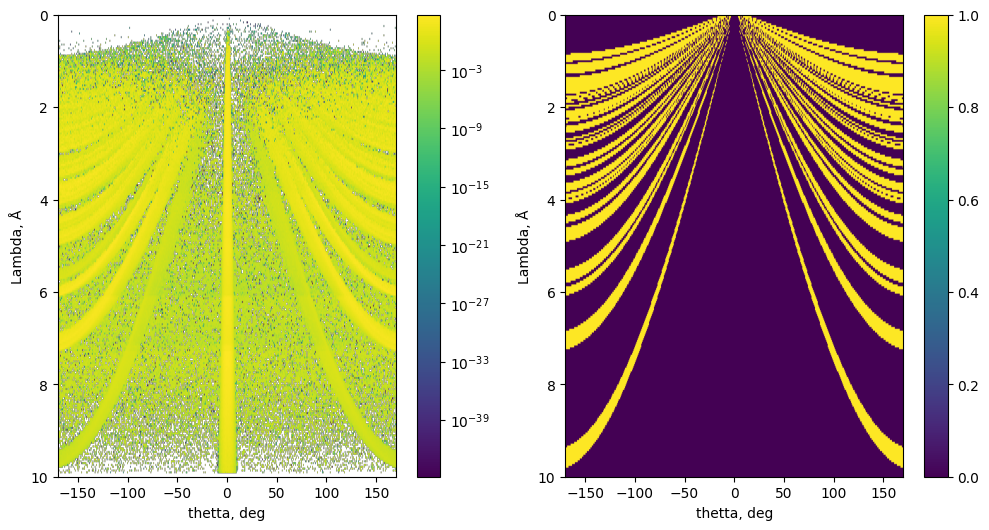

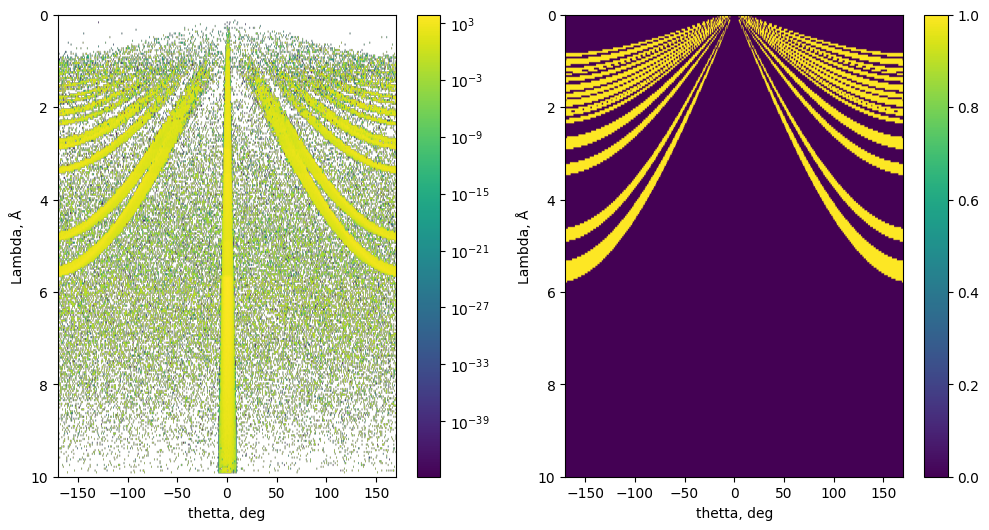

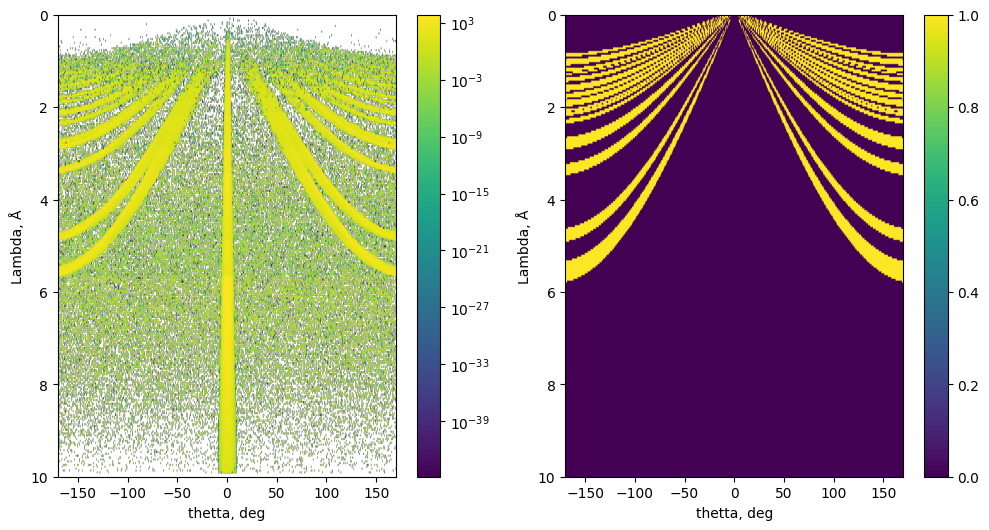

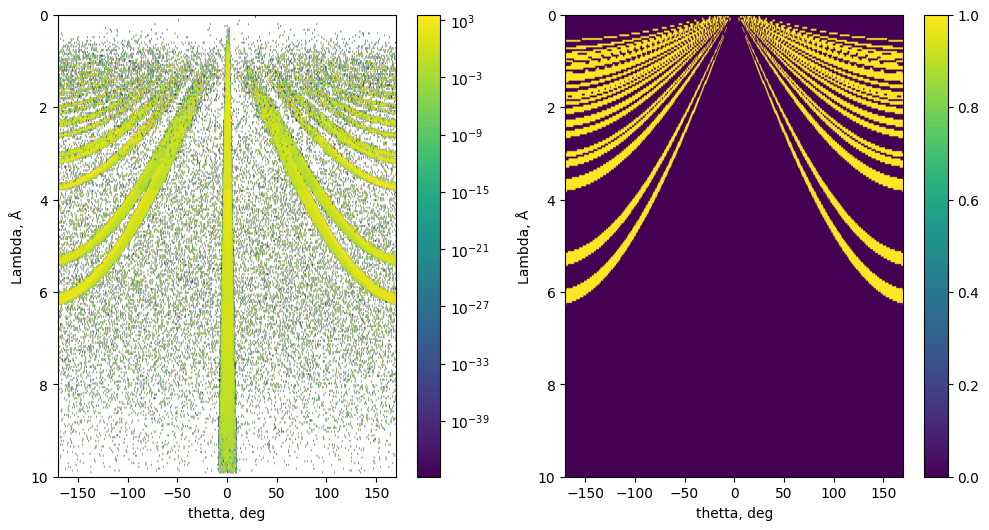

In [12]:
# Загрузка ваших данных (предполагаем, что они уже загружены)
# df = pd.read_pickle('your_data.pkl')
# df_seg_matrices = pd.read_pickle('segmentation_masks.pkl')

# Создаем DataLoader'ы
train_loader, test_loader, train_crystals, test_crystals = create_dataloaders(
    df=df,
    df_seg_matrices=df_seg_maps,
    batch_size=4,
    test_size=0.2,
    shuffle=True,
    random_state=42,
    split_strategy='simple' # 'crystal' 'simple'
)

# Проверяем размерность батча
for diffractions, masks in train_loader:
    print(f"Images shape: {diffractions.shape}")  # [batch_size, 1, H, W]
    print(f"Masks shape: {masks.shape}")    # [batch_size, H, W]

    for diffraction, mask in zip(diffractions, masks):

        # Создаем фигуру и оси
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Первый график
        im1 = ax1.imshow(diffraction[0].cpu().numpy(), cmap='viridis', aspect='auto', norm='log', extent=(-170, 170, 10, 0))
        ax1.set_xlabel('thetta, deg')
        ax1.set_ylabel('Lambda, Å')
        plt.colorbar(im1)

        # Первый график
        im2 = ax2.imshow(mask.cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
        ax2.set_xlabel('thetta, deg')
        ax2.set_ylabel('Lambda, Å')
        plt.colorbar(im2)
    break

In [12]:
import torch.nn as nn
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + smooth) / (union + smooth)

def dice_BCE_loss(pred, target):
    return 0.5 * F.binary_cross_entropy_with_logits(pred, target) + 0.5 * dice_loss(pred, target)


def combo_loss(pred, target, alpha=0.5, beta=0.5, ce_weight=1.0):
    """
    Комбинация нескольких лоссов с акцентом на тонкие структуры
    """
    # BCE с весами
    bce = F.binary_cross_entropy_with_logits(pred, target)
    
    # Dice для структур
    pred_sigmoid = torch.sigmoid(pred)
    intersection = (pred_sigmoid * target).sum()
    dice = 1 - (2. * intersection + 1) / (pred_sigmoid.sum() + target.sum() + 1)
    
    # Boundary-aware component
    # Выделяем тонкие структуры (пиксели с малым количеством соседей)
    kernel = torch.ones(1, 1, 3, 3).to(pred.device)
    neighbor_count = F.conv2d(target.unsqueeze(1), kernel, padding=1)
    thin_pixels = (neighbor_count <= 3) & (target.unsqueeze(1) > 0)
    
    if thin_pixels.sum() > 0:
        thin_loss = F.binary_cross_entropy_with_logits(
            pred, 
            target,
            reduction='none'
        )
        thin_loss = (thin_loss * thin_pixels.squeeze(1)).sum() / (thin_pixels.sum() + 1e-8)
    else:
        thin_loss = 0
    
    return alpha * bce + beta * dice + ce_weight * thin_loss

import torch
import torch.nn.functional as F
from torch import nn

# ---- Dice Loss ----
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, pred_logits, target):
        # pred_logits: (N,1,H,W) logits
        pred = torch.sigmoid(pred_logits)
        target = target.float()
        intersection = (pred * target).sum(dim=[1,2,3])
        union = pred.sum(dim=[1,2,3]) + target.sum(dim=[1,2,3])
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1. - dice.mean()

# ---- Tversky / Focal-Tversky ----
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
    def forward(self, pred_logits, target):
        pred = torch.sigmoid(pred_logits)
        target = target.float()
        TP = (pred * target).sum(dim=[1,2,3])
        FP = (pred * (1-target)).sum(dim=[1,2,3])
        FN = ((1-pred) * target).sum(dim=[1,2,3])
        tversky = (TP + self.eps) / (TP + self.alpha*FP + self.beta*FN + self.eps)
        return 1.0 - tversky.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=0.75):
        super().__init__()
        self.tversky = TverskyLoss(alpha, beta)
        self.gamma = gamma
    def forward(self, pred_logits, target):
        t = 1.0 - self.tversky(pred_logits, target)  # tversky score
        return (1 - t**self.gamma)

# ---- Focal BCE ----
class FocalBCE(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, target):
        bce = F.binary_cross_entropy_with_logits(logits, target.float(), reduction='none')
        pred_prob = torch.sigmoid(logits)
        p_t = target * pred_prob + (1-target) * (1-pred_prob)
        mod = (1 - p_t) ** self.gamma
        loss = self.alpha * mod * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# ---- Combined loss example ----
class CombinedLoss(nn.Module):
    def __init__(self, w_bce=1.0, w_dice=1.0, w_boundary=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.w_bce = w_bce
        self.w_dice = w_dice
        self.w_boundary = w_boundary
    def forward(self, logits, target, boundary_weight_map=None):
        # boundary_weight_map: same shape as target, optional per-pixel weights
        bce_loss = F.binary_cross_entropy_with_logits(logits, target.float(), reduction='none')
        if boundary_weight_map is not None:
            bce_loss = (bce_loss * boundary_weight_map).mean()
        else:
            bce_loss = bce_loss.mean()
        dice_loss = self.dice(logits, target)
        # Optionally add boundary/surface loss term here (see below)
        loss = self.w_bce * bce_loss + self.w_dice * dice_loss
        return loss


In [ ]:
import segmentation_models_pytorch as smp

# Создание модели за одну строку
model = smp.Unet(
    encoder_name="resnet50",        # энкодер из torchvision
    encoder_weights=None,     # предобученные веса
    in_channels=1,                  # входные каналы
    classes=1,                      # классы сегментации
    activation=None # 'sigmoid'           # для бинарной сегментации
).to(device)

# Все доступные энкодеры
print("Available encoders:")
print(smp.encoders.get_encoder_names())

In [ ]:
# Все доступные энкодеры
print("Available encoders:")
print(smp.encoders.get_encoder_names())

Available encoders:
['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'tim

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math

class PatchEmbedding(nn.Module):
    """Разбиение изображения на патчи и линейное проецирование"""
    def __init__(self, img_size=(250, 480), patch_size=(5, 16), in_chans=1, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size_H = patch_size[0]
        self.patch_size_W = patch_size[1]
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        
        self.proj = nn.Conv2d(in_chans, embed_dim, 
                             kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H//patch_size, W//patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    """Позиционное кодирование для патчей"""
    def __init__(self, embed_dim, num_patches):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        return x + self.pos_embed

class MultiHeadAttention(nn.Module):
    """Многоголовое внимание"""
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    """Многослойный персептрон"""
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.1):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    """Трансформер блок"""
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, mlp_hidden_dim, dropout=dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TransformerEncoder(nn.Module):
    """Кодер трансформера"""
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x

class DecoderSimple(nn.Module):
    """Простой декодер для SETR"""
    def __init__(self, embed_dim=768, num_classes=2, img_size=(250, 480), patch_size=(5, 16)):
        super().__init__()
        self.img_size = img_size
        self.patch_size_H = patch_size[0]
        self.patch_size_W = patch_size[1]
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        
        # Подгонка размеров до исходного
        self.decoder = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        # x: (B, num_patches, embed_dim)
        B, N, C = x.shape
        H, W = self.grid_size
        
        # Восстановление пространственной структуры
        x = x.transpose(1, 2).view(B, C, H, W)
        
        # Декодирование
        x = self.decoder(x)
        
        # Интерполяция до исходного размера
        x = F.interpolate(x, size=self.img_size, mode='bilinear', align_corners=True)
        return x

class DecoderMLA(nn.Module):
    """Декодер с мультиуровневой агрегацией (MLA)"""
    def __init__(self, embed_dim=768, num_classes=2, img_size=(250, 480), patch_size=(5, 16)):
        super().__init__()
        self.img_size = img_size
        self.patch_size_H = patch_size[0]
        self.patch_size_W = patch_size[1]
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        
        # MLA layers для разных уровней трансформера
        self.mla_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(embed_dim, 256, kernel_size=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ) for _ in range(4)  # Берем 4 разных уровня
        ])
        
        # Объединение и финальный декодер
        self.fusion = nn.Sequential(
            nn.Conv2d(256 * 4, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        
    def forward(self, features):
        # features: список тензоров из разных уровней энкодера
        mla_features = []
        for i, feat in enumerate(features[-4:]):  # Берем последние 4 уровня
            B, N, C = feat.shape
            H, W = self.grid_size
            feat = feat.transpose(1, 2).view(B, C, H, W)
            feat = self.mla_layers[i](feat)
            mla_features.append(feat)
        
        # Объединение features
        fused = torch.cat(mla_features, dim=1)
        
        # Финальное декодирование
        x = self.fusion(fused)
        x = F.interpolate(x, size=self.img_size, mode='bilinear', align_corners=True)
        return x

class SETR(nn.Module):
    """Основная модель SETR"""
    def __init__(self, img_size=(250, 480), patch_size=(5, 16), in_chans=1, 
                 num_classes=2, embed_dim=768, depth=12, num_heads=12, 
                 mlp_ratio=4.0, decoder_type='simple', dropout=0.1):
        super().__init__()
        
        # Энкодер
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.pos_embed = PositionalEncoding(embed_dim, num_patches)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Трансформер энкодер
        self.encoder = TransformerEncoder(embed_dim, depth, num_heads, mlp_ratio, dropout)
        
        # Декодер
        self.decoder_type = decoder_type
        if decoder_type == 'simple':
            self.decoder = DecoderSimple(embed_dim, num_classes, img_size, patch_size)
        elif decoder_type == 'mla':
            self.decoder = DecoderMLA(embed_dim, num_classes, img_size, patch_size)
        else:
            raise ValueError(f"Unknown decoder type: {decoder_type}")
            
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward_features(self, x):
        # Извлечение патчей
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        x = self.pos_drop(x)
        
        # Сохранение features из разных уровней
        features = []
        for blk in self.encoder.blocks:
            x = blk(x)
            features.append(x)
        x = self.encoder.norm(x)
        features.append(x)
        
        return features
    
    def forward(self, x):
        features = self.forward_features(x)
        x = self.decoder(features)
        return x


class SETRWithIntermediateFeatures(SETR):
    """SETR с сохранением промежуточных features для MLA"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def forward_features(self, x):
        # Извлечение патчей
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        x = self.pos_drop(x)
        
        # Сохранение features из разных уровней
        features = []
        for blk in self.encoder.blocks:
            x = blk(x)
            features.append(x)
        x = self.encoder.norm(x)
        features.append(x)
        
        return features
    
    def forward(self, x):
        features = self.forward_features(x)
        x = self.decoder(features)
        return x

In [36]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Создание модели
model = SETR(
    img_size=(250, 480),
    patch_size=(5, 16),
    in_chans=1,
    num_classes=1,
    embed_dim=512,
    depth=12,
    num_heads=8,
    decoder_type= 'mla' # 'simple'  # или 'mla'
).to(device)

In [32]:
from SwinUNet import SwinUNet

# Создание модели
model = SwinUNet(patch_size=2, in_chans=1, embed_dim=48, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.).to(device)

In [15]:
test = torch.randn(2, 1, 250, 480).to(device)
target = torch.randn(2, 250, 480).to(device)

# model = SimplifiedMask2Former(img_size=(250, 480), backbone='resnet18',
#                  hidden_dim=256, num_queries=75, num_heads=4, num_layers=6).to(device)

# model = UNet().to(device)

with torch.no_grad():
    out = model(test)

print(out.size())
# print(out)

torch.Size([2, 1, 250, 480])


In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Оптимизатор
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Планировщик (опционально)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)  # Уменьшает lr в 10 раз каждые 10 эпох

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import math

# Планировщик с косинусным затуханием и warmup
def get_scheduler(optimizer, warmup_epochs, total_epochs, base_lr):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine annealing
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Попробуйте такую конфигурацию:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,  # Чуть выше начальный LR
    betas=(0.9, 0.999),
    eps=1e-8,  # Стандартное значение
    weight_decay=1e-4  # Увеличьте weight decay для лучшей регуляризации
)

# Использование:
scheduler = get_scheduler(optimizer, warmup_epochs=10, total_epochs=300, base_lr=1e-4)

In [ ]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import random

def train_epoch(
    model,
    loss_fn, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler, 
    device, 
    scaler,
    epoch_num, 
    num_epochs, 
    use_fp16
):
    """
    Обучает модель на одной эпохе
    
    Args:
        model: модель для обучения
        loss_fn: loss функция для обучения
        train_loader: DataLoader для тренировочных данных
        val_loader: DataLoader для валидационных данных
        optimizer: оптимизатор
        scheduler: планировщик обучения
        device: устройство (cuda/cpu)
        scaler: GradScaler для FP16
        epoch_num: номер текущей эпохи
        num_epochs: общее количество эпох
        use_fp16: флаг использования FP16 (по умолчанию True)
    
    Returns:
        tuple: (средний тренировочный лосс, средний валидационный лосс)
    """
    # Обучение
    model.train()
    train_loss = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch_num+1} Train", leave=False):
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        # mu = random.randint(50, 200)
        mu = 100
        sigma = 0.2*mu
        
        # Создаем шум на том же устройстве
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise
        
        optimizer.zero_grad()
        
        if use_fp16:
            # FP16 forward
            with autocast():
                pred = model(images)
                loss = loss_fn(pred, masks)
            
            # Масштабируем градиенты и делаем backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # FP32 forward
            pred = model(images)
            loss = loss_fn(pred, masks)

            loss.backward()
            optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # Валидация
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch_num+1} Val", leave=False):
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            # mu = random.randint(50, 200)
            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(images, device=device) * sigma + mu
            images = images + noise
            
            if use_fp16:
                with autocast():
                    pred = model(images)
                    loss = loss_fn(pred, masks)
            else:
                pred = model(images)
                loss = loss_fn(pred, masks)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    
    # Обновление планировщика
    scheduler.step()
    
    # Вывод информации об эпохе
    print(f"Epoch [{epoch_num+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.6f} "
          f"Val Loss: {avg_val_loss:.6f} "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    return avg_train_loss, avg_val_loss

In [34]:
import torch
from torch.cuda.amp import GradScaler

# Инициализация скалера только если используется FP16
use_fp16 = True  # Можно менять на False для отключения FP16
scaler = GradScaler() if use_fp16 else None

# История для отслеживания метрик
history_train = []
history_val = []

# Главный цикл обучения
num_epochs = 300
for epoch in range(num_epochs):
    train_loss, val_loss = train_epoch(
        model=model,
        loss_fn=CombinedLoss(w_bce=1.0, w_dice=1.0),
        train_loader=train_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        scaler=scaler,
        epoch_num=epoch,
        num_epochs=num_epochs,
        use_fp16=use_fp16
    )
    
    history_train.append(train_loss)
    history_val.append(val_loss)

Epoch [1/300] Train Loss: 0.293985 Val Loss: 0.269945 LR: 2.00e-04


Epoch [2/300] Train Loss: 0.268154 Val Loss: 0.265526 LR: 2.00e-04


Epoch [3/300] Train Loss: 0.262791 Val Loss: 0.263295 LR: 2.00e-04


Epoch [4/300] Train Loss: 0.249947 Val Loss: 0.248806 LR: 2.00e-04


Epoch [5/300] Train Loss: 0.244873 Val Loss: 0.249529 LR: 2.00e-04


Epoch [6/300] Train Loss: 0.240234 Val Loss: 0.237545 LR: 2.00e-04


Epoch [7/300] Train Loss: 0.236328 Val Loss: 0.243183 LR: 2.00e-04


Epoch [8/300] Train Loss: 0.232287 Val Loss: 0.243636 LR: 2.00e-04


Epoch [9/300] Train Loss: 0.228053 Val Loss: 0.222688 LR: 2.00e-04


Epoch [10/300] Train Loss: 0.223627 Val Loss: 0.231718 LR: 2.00e-04


Epoch [11/300] Train Loss: 0.219757 Val Loss: 0.215850 LR: 2.00e-04


Epoch [12/300] Train Loss: 0.217041 Val Loss: 0.217808 LR: 2.00e-04


Epoch [13/300] Train Loss: 0.214576 Val Loss: 0.212332 LR: 2.00e-04


Epoch [14/300] Train Loss: 0.210217 Val Loss: 0.212003 LR: 2.00e-04


Epoch [15/300] Train Loss: 0.209901 Val Loss: 0.211751 LR: 2.00e-04


Epoch [16/300] Train Loss: 0.206321 Val Loss: 0.206947 LR: 2.00e-04


Epoch [17/300] Train Loss: 0.204139 Val Loss: 0.208756 LR: 2.00e-04


Epoch [18/300] Train Loss: 0.204475 Val Loss: 0.204132 LR: 2.00e-04


Epoch [19/300] Train Loss: 0.200457 Val Loss: 0.206895 LR: 2.00e-04


Epoch [20/300] Train Loss: 0.199624 Val Loss: 0.200619 LR: 2.00e-04


Epoch [21/300] Train Loss: 0.195114 Val Loss: 0.196400 LR: 2.00e-04


Epoch [22/300] Train Loss: 0.192818 Val Loss: 0.201879 LR: 2.00e-04


Epoch [23/300] Train Loss: 0.194655 Val Loss: 0.195926 LR: 2.00e-04


Epoch [24/300] Train Loss: 0.190888 Val Loss: 0.194255 LR: 2.00e-04


Epoch [25/300] Train Loss: 0.188625 Val Loss: 0.190270 LR: 2.00e-04


Epoch [26/300] Train Loss: 0.186968 Val Loss: 0.192844 LR: 2.00e-04


Epoch [27/300] Train Loss: 0.186442 Val Loss: 0.188788 LR: 2.00e-04


Epoch [28/300] Train Loss: 0.182713 Val Loss: 0.188804 LR: 2.00e-04


Epoch [29/300] Train Loss: 0.182665 Val Loss: 0.187749 LR: 2.00e-04


Epoch [30/300] Train Loss: 0.180480 Val Loss: 0.185156 LR: 2.00e-04


Epoch [31/300] Train Loss: 0.178719 Val Loss: 0.191297 LR: 2.00e-04


Epoch [32/300] Train Loss: 0.178427 Val Loss: 0.182958 LR: 2.00e-04


Epoch [33/300] Train Loss: 0.176102 Val Loss: 0.182536 LR: 2.00e-04


Epoch [34/300] Train Loss: 0.177041 Val Loss: 0.187324 LR: 2.00e-04


Epoch [35/300] Train Loss: 0.174461 Val Loss: 0.179925 LR: 2.00e-04


Epoch [36/300] Train Loss: 0.174827 Val Loss: 0.178013 LR: 2.00e-04


Epoch [37/300] Train Loss: 0.173390 Val Loss: 0.178431 LR: 2.00e-04


Epoch [38/300] Train Loss: 0.171533 Val Loss: 0.178298 LR: 2.00e-04


Epoch [39/300] Train Loss: 0.170146 Val Loss: 0.176745 LR: 2.00e-04


Epoch [40/300] Train Loss: 0.169111 Val Loss: 0.173900 LR: 2.00e-04


Epoch [41/300] Train Loss: 0.168375 Val Loss: 0.174899 LR: 2.00e-04


Epoch [42/300] Train Loss: 0.167393 Val Loss: 0.173410 LR: 2.00e-04


Epoch [43/300] Train Loss: 0.165666 Val Loss: 0.175178 LR: 2.00e-04


Epoch [44/300] Train Loss: 0.165500 Val Loss: 0.172040 LR: 2.00e-04


Epoch [45/300] Train Loss: 0.164276 Val Loss: 0.170193 LR: 2.00e-04


Epoch [46/300] Train Loss: 0.162421 Val Loss: 0.166421 LR: 2.00e-04


Epoch [47/300] Train Loss: 0.161554 Val Loss: 0.168140 LR: 2.00e-04


Epoch [48/300] Train Loss: 0.160863 Val Loss: 0.166971 LR: 2.00e-04


Epoch [49/300] Train Loss: 0.160195 Val Loss: 0.164201 LR: 2.00e-04


Epoch [50/300] Train Loss: 0.158237 Val Loss: 0.169802 LR: 2.00e-04


Epoch [51/300] Train Loss: 0.157127 Val Loss: 0.159690 LR: 2.00e-04


Epoch [52/300] Train Loss: 0.154765 Val Loss: 0.162192 LR: 2.00e-04


Epoch [53/300] Train Loss: 0.155995 Val Loss: 0.161005 LR: 2.00e-04


Epoch [54/300] Train Loss: 0.154599 Val Loss: 0.159841 LR: 2.00e-04


Epoch [55/300] Train Loss: 0.153058 Val Loss: 0.158816 LR: 2.00e-04


Epoch [56/300] Train Loss: 0.152523 Val Loss: 0.161088 LR: 2.00e-04


Epoch [57/300] Train Loss: 0.151120 Val Loss: 0.161471 LR: 2.00e-04


Epoch [58/300] Train Loss: 0.150270 Val Loss: 0.155065 LR: 2.00e-04


Epoch [59/300] Train Loss: 0.150280 Val Loss: 0.158449 LR: 2.00e-04


Epoch [60/300] Train Loss: 0.147808 Val Loss: 0.152433 LR: 2.00e-04


Epoch [61/300] Train Loss: 0.145368 Val Loss: 0.154306 LR: 2.00e-04


Epoch [62/300] Train Loss: 0.141163 Val Loss: 0.148464 LR: 2.00e-04


Epoch [63/300] Train Loss: 0.137523 Val Loss: 0.136725 LR: 2.00e-04


Epoch [64/300] Train Loss: 0.140061 Val Loss: 0.139118 LR: 2.00e-04


Epoch [65/300] Train Loss: 0.130105 Val Loss: 0.130186 LR: 2.00e-04


Epoch [66/300] Train Loss: 0.130150 Val Loss: 0.141385 LR: 2.00e-04


Epoch [67/300] Train Loss: 0.123024 Val Loss: 0.127334 LR: 2.00e-04


Epoch [68/300] Train Loss: 0.119200 Val Loss: 0.124514 LR: 2.00e-04


Epoch [69/300] Train Loss: 0.117567 Val Loss: 0.124843 LR: 2.00e-04


Epoch [70/300] Train Loss: 0.118261 Val Loss: 0.129684 LR: 2.00e-04


Epoch [71/300] Train Loss: 0.117228 Val Loss: 0.118101 LR: 2.00e-04


Epoch [72/300] Train Loss: 0.114596 Val Loss: 0.125743 LR: 2.00e-04


Epoch [73/300] Train Loss: 0.113493 Val Loss: 0.118780 LR: 2.00e-04


Epoch [74/300] Train Loss: 0.110043 Val Loss: 0.113847 LR: 2.00e-04


Epoch [75/300] Train Loss: 0.109256 Val Loss: 0.114662 LR: 2.00e-04


Epoch [76/300] Train Loss: 0.106706 Val Loss: 0.108724 LR: 2.00e-04


Epoch [77/300] Train Loss: 0.107045 Val Loss: 0.111079 LR: 2.00e-04


Epoch [78/300] Train Loss: 0.105502 Val Loss: 0.111627 LR: 2.00e-04


Epoch [79/300] Train Loss: 0.104587 Val Loss: 0.116994 LR: 2.00e-04


Epoch [80/300] Train Loss: 0.104532 Val Loss: 0.112077 LR: 2.00e-04


Epoch [81/300] Train Loss: 0.101983 Val Loss: 0.105609 LR: 2.00e-04


Epoch [82/300] Train Loss: 0.105015 Val Loss: 0.115250 LR: 2.00e-04


Epoch [83/300] Train Loss: 0.100765 Val Loss: 0.104234 LR: 2.00e-04


Epoch [84/300] Train Loss: 0.101133 Val Loss: 0.107428 LR: 2.00e-04


Epoch [85/300] Train Loss: 0.097981 Val Loss: 0.104968 LR: 2.00e-04


Epoch [86/300] Train Loss: 0.098281 Val Loss: 0.103123 LR: 2.00e-04


Epoch [87/300] Train Loss: 0.098047 Val Loss: 0.102575 LR: 2.00e-04


Epoch [88/300] Train Loss: 0.099429 Val Loss: 0.106092 LR: 2.00e-04


Epoch [89/300] Train Loss: 0.097599 Val Loss: 0.103185 LR: 2.00e-04


Epoch [90/300] Train Loss: 0.094646 Val Loss: 0.100446 LR: 2.00e-04


Epoch [91/300] Train Loss: 0.095093 Val Loss: 0.113349 LR: 2.00e-04


Epoch [92/300] Train Loss: 0.093743 Val Loss: 0.098214 LR: 2.00e-04


Epoch [93/300] Train Loss: 0.093646 Val Loss: 0.096907 LR: 2.00e-04


Epoch [94/300] Train Loss: 0.091718 Val Loss: 0.098916 LR: 2.00e-04


Epoch [95/300] Train Loss: 0.093695 Val Loss: 0.096879 LR: 2.00e-04


Epoch [96/300] Train Loss: 0.091680 Val Loss: 0.096674 LR: 2.00e-04


Epoch [97/300] Train Loss: 0.090448 Val Loss: 0.092459 LR: 2.00e-04


Epoch [98/300] Train Loss: 0.088938 Val Loss: 0.093748 LR: 2.00e-04


Epoch [99/300] Train Loss: 0.090474 Val Loss: 0.099011 LR: 2.00e-04


Epoch [100/300] Train Loss: 0.088206 Val Loss: 0.096501 LR: 2.00e-04


Epoch [101/300] Train Loss: 0.088935 Val Loss: 0.092654 LR: 2.00e-04


Epoch [102/300] Train Loss: 0.086349 Val Loss: 0.087414 LR: 2.00e-04


Epoch [103/300] Train Loss: 0.086010 Val Loss: 0.091102 LR: 2.00e-04


Epoch [104/300] Train Loss: 0.087355 Val Loss: 0.087902 LR: 2.00e-04


Epoch [105/300] Train Loss: 0.084418 Val Loss: 0.096357 LR: 2.00e-04


Epoch [106/300] Train Loss: 0.083752 Val Loss: 0.087873 LR: 2.00e-04


Epoch [107/300] Train Loss: 0.084416 Val Loss: 0.087160 LR: 2.00e-04


Epoch [108/300] Train Loss: 0.082182 Val Loss: 0.086559 LR: 2.00e-04


Epoch [109/300] Train Loss: 0.083167 Val Loss: 0.085977 LR: 2.00e-04


Epoch [110/300] Train Loss: 0.081219 Val Loss: 0.087135 LR: 2.00e-04


Epoch [111/300] Train Loss: 0.081518 Val Loss: 0.087616 LR: 2.00e-04


Epoch [112/300] Train Loss: 0.081902 Val Loss: 0.094254 LR: 2.00e-04


Epoch [113/300] Train Loss: 0.085154 Val Loss: 0.085376 LR: 2.00e-04


Epoch [114/300] Train Loss: 0.080026 Val Loss: 0.083849 LR: 2.00e-04


Epoch [115/300] Train Loss: 0.083131 Val Loss: 0.087440 LR: 2.00e-04


Epoch [116/300] Train Loss: 0.079690 Val Loss: 0.083282 LR: 2.00e-04


Epoch [117/300] Train Loss: 0.077949 Val Loss: 0.087252 LR: 2.00e-04


Epoch [118/300] Train Loss: 0.079930 Val Loss: 0.084376 LR: 2.00e-04


Epoch [119/300] Train Loss: 0.077242 Val Loss: 0.080110 LR: 2.00e-04


Epoch [120/300] Train Loss: 0.076340 Val Loss: 0.080519 LR: 2.00e-04


Epoch [121/300] Train Loss: 0.078977 Val Loss: 0.080982 LR: 2.00e-04


Epoch [122/300] Train Loss: 0.076089 Val Loss: 0.079830 LR: 2.00e-04


Epoch [123/300] Train Loss: 0.077702 Val Loss: 0.080483 LR: 2.00e-04


Epoch [124/300] Train Loss: 0.076849 Val Loss: 0.079730 LR: 2.00e-04


Epoch [125/300] Train Loss: 0.076711 Val Loss: 0.080190 LR: 2.00e-04


Epoch [126/300] Train Loss: 0.074731 Val Loss: 0.082462 LR: 2.00e-04


Epoch [127/300] Train Loss: 0.077836 Val Loss: 0.096299 LR: 2.00e-04


Epoch [128/300] Train Loss: 0.075931 Val Loss: 0.084269 LR: 2.00e-04


Epoch [129/300] Train Loss: 0.073702 Val Loss: 0.081051 LR: 2.00e-04


Epoch [130/300] Train Loss: 0.075716 Val Loss: 0.088432 LR: 2.00e-04


Epoch [131/300] Train Loss: 0.075791 Val Loss: 0.078142 LR: 2.00e-04


Epoch [132/300] Train Loss: 0.073272 Val Loss: 0.082566 LR: 2.00e-04


Epoch [133/300] Train Loss: 0.073532 Val Loss: 0.076241 LR: 2.00e-04


Epoch [134/300] Train Loss: 0.073669 Val Loss: 0.077798 LR: 2.00e-04


Epoch [135/300] Train Loss: 0.072573 Val Loss: 0.076101 LR: 2.00e-04


Epoch [136/300] Train Loss: 0.074070 Val Loss: 0.077752 LR: 2.00e-04


Epoch [137/300] Train Loss: 0.072918 Val Loss: 0.076184 LR: 2.00e-04


Epoch [138/300] Train Loss: 0.075263 Val Loss: 0.078534 LR: 2.00e-04


Epoch [139/300] Train Loss: 0.073882 Val Loss: 0.079062 LR: 2.00e-04


Epoch [140/300] Train Loss: 0.072776 Val Loss: 0.077991 LR: 2.00e-04


Epoch [141/300] Train Loss: 0.071460 Val Loss: 0.077012 LR: 2.00e-04


Epoch [142/300] Train Loss: 0.072059 Val Loss: 0.074979 LR: 2.00e-04


Epoch [143/300] Train Loss: 0.070824 Val Loss: 0.076832 LR: 2.00e-04


Epoch [144/300] Train Loss: 0.071767 Val Loss: 0.077651 LR: 2.00e-04


Epoch [145/300] Train Loss: 0.071903 Val Loss: 0.079781 LR: 2.00e-04


Epoch [146/300] Train Loss: 0.071301 Val Loss: 0.075593 LR: 2.00e-04


Epoch [147/300] Train Loss: 0.070412 Val Loss: 0.075826 LR: 2.00e-04


Epoch [148/300] Train Loss: 0.071306 Val Loss: 0.075918 LR: 2.00e-04


Epoch [149/300] Train Loss: 0.070749 Val Loss: 0.075072 LR: 2.00e-04


Epoch [150/300] Train Loss: 0.070625 Val Loss: 0.074583 LR: 2.00e-04


Epoch [151/300] Train Loss: 0.069381 Val Loss: 0.076585 LR: 2.00e-04


Epoch [152/300] Train Loss: 0.069802 Val Loss: 0.075044 LR: 2.00e-04


Epoch [153/300] Train Loss: 0.069093 Val Loss: 0.075624 LR: 2.00e-04


Epoch [154/300] Train Loss: 0.069072 Val Loss: 0.076815 LR: 2.00e-04


Epoch [155/300] Train Loss: 0.069295 Val Loss: 0.073424 LR: 2.00e-04


Epoch [156/300] Train Loss: 0.068799 Val Loss: 0.081636 LR: 2.00e-04


Epoch [157/300] Train Loss: 0.068752 Val Loss: 0.085806 LR: 2.00e-04


Epoch [158/300] Train Loss: 0.071046 Val Loss: 0.073565 LR: 2.00e-04


Epoch [159/300] Train Loss: 0.067496 Val Loss: 0.078506 LR: 2.00e-04


Epoch [160/300] Train Loss: 0.068089 Val Loss: 0.073449 LR: 2.00e-04


Epoch [161/300] Train Loss: 0.067598 Val Loss: 0.074680 LR: 2.00e-04


Epoch [162/300] Train Loss: 0.067884 Val Loss: 0.074491 LR: 2.00e-04


Epoch [163/300] Train Loss: 0.067315 Val Loss: 0.078065 LR: 2.00e-04


Epoch [164/300] Train Loss: 0.067627 Val Loss: 0.072796 LR: 2.00e-04


Epoch [165/300] Train Loss: 0.067292 Val Loss: 0.074179 LR: 2.00e-04


Epoch [166/300] Train Loss: 0.068401 Val Loss: 0.074042 LR: 2.00e-04


Epoch [167/300] Train Loss: 0.067522 Val Loss: 0.071006 LR: 2.00e-04


Epoch [168/300] Train Loss: 0.068051 Val Loss: 0.076503 LR: 2.00e-04


Epoch [169/300] Train Loss: 0.068346 Val Loss: 0.071306 LR: 2.00e-04


Epoch [170/300] Train Loss: 0.067041 Val Loss: 0.073986 LR: 2.00e-04


Epoch [171/300] Train Loss: 0.067710 Val Loss: 0.071143 LR: 2.00e-04


Epoch [172/300] Train Loss: 0.067795 Val Loss: 0.069142 LR: 2.00e-04


Epoch [173/300] Train Loss: 0.066625 Val Loss: 0.071227 LR: 2.00e-04


Epoch [174/300] Train Loss: 0.065384 Val Loss: 0.071498 LR: 2.00e-04


Epoch [175/300] Train Loss: 0.066188 Val Loss: 0.069584 LR: 2.00e-04


Epoch [176/300] Train Loss: 0.065395 Val Loss: 0.073430 LR: 2.00e-04


Epoch [177/300] Train Loss: 0.066489 Val Loss: 0.072171 LR: 2.00e-04


Epoch [178/300] Train Loss: 0.066170 Val Loss: 0.072685 LR: 2.00e-04


Epoch [179/300] Train Loss: 0.066241 Val Loss: 0.069464 LR: 2.00e-04


Epoch [180/300] Train Loss: 0.066276 Val Loss: 0.068960 LR: 2.00e-04


Epoch [181/300] Train Loss: 0.069427 Val Loss: 0.070531 LR: 2.00e-04


Epoch [182/300] Train Loss: 0.065425 Val Loss: 0.070957 LR: 2.00e-04


Epoch [183/300] Train Loss: 0.064963 Val Loss: 0.070226 LR: 2.00e-04


Epoch [184/300] Train Loss: 0.066627 Val Loss: 0.069816 LR: 2.00e-04


Epoch [185/300] Train Loss: 0.064732 Val Loss: 0.069031 LR: 2.00e-04


Epoch [186/300] Train Loss: 0.065215 Val Loss: 0.071436 LR: 2.00e-04


Epoch [187/300] Train Loss: 0.065443 Val Loss: 0.073703 LR: 2.00e-04


Epoch [188/300] Train Loss: 0.065670 Val Loss: 0.070515 LR: 2.00e-04


Epoch [189/300] Train Loss: 0.064358 Val Loss: 0.071259 LR: 2.00e-04


Epoch [190/300] Train Loss: 0.066146 Val Loss: 0.069111 LR: 2.00e-04


Epoch [191/300] Train Loss: 0.064375 Val Loss: 0.069649 LR: 2.00e-04


Epoch [192/300] Train Loss: 0.064361 Val Loss: 0.071342 LR: 2.00e-04


Epoch [193/300] Train Loss: 0.064010 Val Loss: 0.070455 LR: 2.00e-04


Epoch [194/300] Train Loss: 0.063929 Val Loss: 0.068365 LR: 2.00e-04


Epoch [195/300] Train Loss: 0.063959 Val Loss: 0.068218 LR: 2.00e-04


Epoch [196/300] Train Loss: 0.064230 Val Loss: 0.077760 LR: 2.00e-04


Epoch [197/300] Train Loss: 0.066279 Val Loss: 0.070448 LR: 2.00e-04


Epoch [198/300] Train Loss: 0.065174 Val Loss: 0.074182 LR: 2.00e-04


Epoch [199/300] Train Loss: 0.064682 Val Loss: 0.070981 LR: 2.00e-04


Epoch [200/300] Train Loss: 0.063748 Val Loss: 0.070593 LR: 2.00e-04


Epoch [201/300] Train Loss: 0.064905 Val Loss: 0.076648 LR: 2.00e-04


Epoch [202/300] Train Loss: 0.065097 Val Loss: 0.073139 LR: 2.00e-04


Epoch [203/300] Train Loss: 0.062759 Val Loss: 0.070755 LR: 2.00e-04


Epoch [204/300] Train Loss: 0.063260 Val Loss: 0.068737 LR: 2.00e-04


Epoch [205/300] Train Loss: 0.062702 Val Loss: 0.069496 LR: 2.00e-04


Epoch [206/300] Train Loss: 0.064686 Val Loss: 0.071401 LR: 2.00e-04


Epoch [207/300] Train Loss: 0.063748 Val Loss: 0.068153 LR: 2.00e-04


Epoch [208/300] Train Loss: 0.063660 Val Loss: 0.069574 LR: 2.00e-04


Epoch [209/300] Train Loss: 0.064207 Val Loss: 0.072465 LR: 2.00e-04


Epoch [210/300] Train Loss: 0.063068 Val Loss: 0.071123 LR: 2.00e-04


Epoch [211/300] Train Loss: 0.063050 Val Loss: 0.068321 LR: 2.00e-04


Epoch [212/300] Train Loss: 0.063241 Val Loss: 0.069195 LR: 2.00e-04


Epoch [213/300] Train Loss: 0.062191 Val Loss: 0.065707 LR: 2.00e-04


Epoch [214/300] Train Loss: 0.061883 Val Loss: 0.071213 LR: 2.00e-04


Epoch [215/300] Train Loss: 0.063715 Val Loss: 0.067530 LR: 2.00e-04


Epoch [216/300] Train Loss: 0.063415 Val Loss: 0.067732 LR: 2.00e-04


Epoch [217/300] Train Loss: 0.062532 Val Loss: 0.068475 LR: 2.00e-04


Epoch [218/300] Train Loss: 0.061967 Val Loss: 0.067321 LR: 2.00e-04


Epoch [219/300] Train Loss: 0.062533 Val Loss: 0.072126 LR: 2.00e-04


Epoch [220/300] Train Loss: 0.064195 Val Loss: 0.068357 LR: 2.00e-04


Epoch [221/300] Train Loss: 0.063374 Val Loss: 0.070373 LR: 2.00e-04


Epoch [222/300] Train Loss: 0.062469 Val Loss: 0.070834 LR: 2.00e-04


Epoch [223/300] Train Loss: 0.062561 Val Loss: 0.073254 LR: 2.00e-04


Epoch [224/300] Train Loss: 0.062361 Val Loss: 0.077769 LR: 2.00e-04


Epoch [225/300] Train Loss: 0.062159 Val Loss: 0.067513 LR: 2.00e-04


Epoch [226/300] Train Loss: 0.061925 Val Loss: 0.069544 LR: 2.00e-04


Epoch [227/300] Train Loss: 0.062276 Val Loss: 0.067461 LR: 2.00e-04


Epoch [228/300] Train Loss: 0.062613 Val Loss: 0.066637 LR: 2.00e-04


Epoch [229/300] Train Loss: 0.061717 Val Loss: 0.070125 LR: 2.00e-04


Epoch [230/300] Train Loss: 0.062193 Val Loss: 0.069025 LR: 2.00e-04


Epoch [231/300] Train Loss: 0.061549 Val Loss: 0.067315 LR: 2.00e-04


Epoch [232/300] Train Loss: 0.061673 Val Loss: 0.067148 LR: 2.00e-04


Epoch [233/300] Train Loss: 0.062414 Val Loss: 0.067008 LR: 2.00e-04


Epoch [234/300] Train Loss: 0.060885 Val Loss: 0.067778 LR: 2.00e-04


Epoch [235/300] Train Loss: 0.062638 Val Loss: 0.069070 LR: 2.00e-04


Epoch [236/300] Train Loss: 0.062856 Val Loss: 0.067329 LR: 2.00e-04


Epoch [237/300] Train Loss: 0.061505 Val Loss: 0.066570 LR: 2.00e-04


Epoch [238/300] Train Loss: 0.061528 Val Loss: 0.069786 LR: 2.00e-04


Epoch [239/300] Train Loss: 0.061624 Val Loss: 0.066712 LR: 2.00e-04


Epoch [240/300] Train Loss: 0.061345 Val Loss: 0.066993 LR: 2.00e-04


Epoch [241/300] Train Loss: 0.061311 Val Loss: 0.065520 LR: 2.00e-04


Epoch [242/300] Train Loss: 0.061452 Val Loss: 0.069055 LR: 2.00e-04


Epoch [243/300] Train Loss: 0.061090 Val Loss: 0.068418 LR: 2.00e-04


Epoch [244/300] Train Loss: 0.063375 Val Loss: 0.068600 LR: 2.00e-04


Epoch [245/300] Train Loss: 0.060637 Val Loss: 0.067510 LR: 2.00e-04


Epoch [246/300] Train Loss: 0.060731 Val Loss: 0.065303 LR: 2.00e-04


Epoch [247/300] Train Loss: 0.060804 Val Loss: 0.066782 LR: 2.00e-04


Epoch [248/300] Train Loss: 0.060944 Val Loss: 0.064663 LR: 2.00e-04


Epoch [249/300] Train Loss: 0.060732 Val Loss: 0.066868 LR: 2.00e-04


Epoch [250/300] Train Loss: 0.060919 Val Loss: 0.066627 LR: 2.00e-04


Epoch [251/300] Train Loss: 0.060683 Val Loss: 0.069601 LR: 2.00e-04


Epoch [252/300] Train Loss: 0.060427 Val Loss: 0.065583 LR: 2.00e-04


Epoch [253/300] Train Loss: 0.060084 Val Loss: 0.065020 LR: 2.00e-04


Epoch [254/300] Train Loss: 0.060623 Val Loss: 0.070689 LR: 2.00e-04


Epoch [255/300] Train Loss: 0.060279 Val Loss: 0.068683 LR: 2.00e-04


Epoch [256/300] Train Loss: 0.061863 Val Loss: 0.067953 LR: 2.00e-04


Epoch [257/300] Train Loss: 0.060696 Val Loss: 0.065012 LR: 2.00e-04


Epoch [258/300] Train Loss: 0.062032 Val Loss: 0.068781 LR: 2.00e-04


Epoch [259/300] Train Loss: 0.060839 Val Loss: 0.065179 LR: 2.00e-04


Epoch [260/300] Train Loss: 0.060026 Val Loss: 0.066751 LR: 2.00e-04


Epoch [261/300] Train Loss: 0.059919 Val Loss: 0.066078 LR: 2.00e-04


Epoch [262/300] Train Loss: 0.060189 Val Loss: 0.066456 LR: 2.00e-04


Epoch [263/300] Train Loss: 0.060074 Val Loss: 0.068352 LR: 2.00e-04


Epoch [264/300] Train Loss: 0.060678 Val Loss: 0.064496 LR: 2.00e-04


Epoch [265/300] Train Loss: 0.060013 Val Loss: 0.065977 LR: 2.00e-04


Epoch [266/300] Train Loss: 0.060251 Val Loss: 0.067686 LR: 2.00e-04


Epoch [267/300] Train Loss: 0.061861 Val Loss: 0.065330 LR: 2.00e-04


Epoch [268/300] Train Loss: 0.059572 Val Loss: 0.068288 LR: 2.00e-04


Epoch [269/300] Train Loss: 0.059756 Val Loss: 0.067277 LR: 2.00e-04


Epoch [270/300] Train Loss: 0.059494 Val Loss: 0.065587 LR: 2.00e-04


Epoch [271/300] Train Loss: 0.060459 Val Loss: 0.066341 LR: 2.00e-04


Epoch [272/300] Train Loss: 0.063485 Val Loss: 0.075003 LR: 2.00e-04


Epoch [273/300] Train Loss: 0.061859 Val Loss: 0.069007 LR: 2.00e-04


Epoch [274/300] Train Loss: 0.059167 Val Loss: 0.066009 LR: 2.00e-04


Epoch [275/300] Train Loss: 0.059172 Val Loss: 0.063490 LR: 2.00e-04


Epoch [276/300] Train Loss: 0.059400 Val Loss: 0.069373 LR: 2.00e-04


Epoch [277/300] Train Loss: 0.060212 Val Loss: 0.066727 LR: 2.00e-04


Epoch [278/300] Train Loss: 0.059958 Val Loss: 0.066037 LR: 2.00e-04


Epoch [279/300] Train Loss: 0.059942 Val Loss: 0.065384 LR: 2.00e-04


Epoch [280/300] Train Loss: 0.059098 Val Loss: 0.066860 LR: 2.00e-04


Epoch [281/300] Train Loss: 0.058803 Val Loss: 0.066877 LR: 2.00e-04


Epoch [282/300] Train Loss: 0.059665 Val Loss: 0.066492 LR: 2.00e-04


Epoch [283/300] Train Loss: 0.059992 Val Loss: 0.064663 LR: 2.00e-04


Epoch [284/300] Train Loss: 0.059643 Val Loss: 0.066655 LR: 2.00e-04


Epoch [285/300] Train Loss: 0.059038 Val Loss: 0.064321 LR: 2.00e-04


Epoch [286/300] Train Loss: 0.060686 Val Loss: 0.063978 LR: 2.00e-04


Epoch [287/300] Train Loss: 0.058622 Val Loss: 0.064505 LR: 2.00e-04


Epoch [288/300] Train Loss: 0.058561 Val Loss: 0.063700 LR: 2.00e-04


Epoch [289/300] Train Loss: 0.059479 Val Loss: 0.065681 LR: 2.00e-04


Epoch [290/300] Train Loss: 0.059808 Val Loss: 0.065443 LR: 2.00e-04


Epoch [291/300] Train Loss: 0.059908 Val Loss: 0.067757 LR: 2.00e-04


Epoch [292/300] Train Loss: 0.060181 Val Loss: 0.065896 LR: 2.00e-04


Epoch [293/300] Train Loss: 0.059232 Val Loss: 0.066708 LR: 2.00e-04


Epoch [294/300] Train Loss: 0.058850 Val Loss: 0.063842 LR: 2.00e-04


Epoch [295/300] Train Loss: 0.058359 Val Loss: 0.065178 LR: 2.00e-04


Epoch [296/300] Train Loss: 0.059907 Val Loss: 0.063691 LR: 2.00e-04


Epoch [297/300] Train Loss: 0.058521 Val Loss: 0.063086 LR: 2.00e-04


Epoch [298/300] Train Loss: 0.059001 Val Loss: 0.063921 LR: 2.00e-04


Epoch [299/300] Train Loss: 0.058505 Val Loss: 0.066627 LR: 2.00e-04


Epoch [300/300] Train Loss: 0.058736 Val Loss: 0.065594 LR: 2.00e-04


In [35]:
print(train_loss)
print(val_loss)

0.058735605174054704
0.06559364888817072


In [36]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.figure(figsize=(20, 6))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.yscale('log')
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

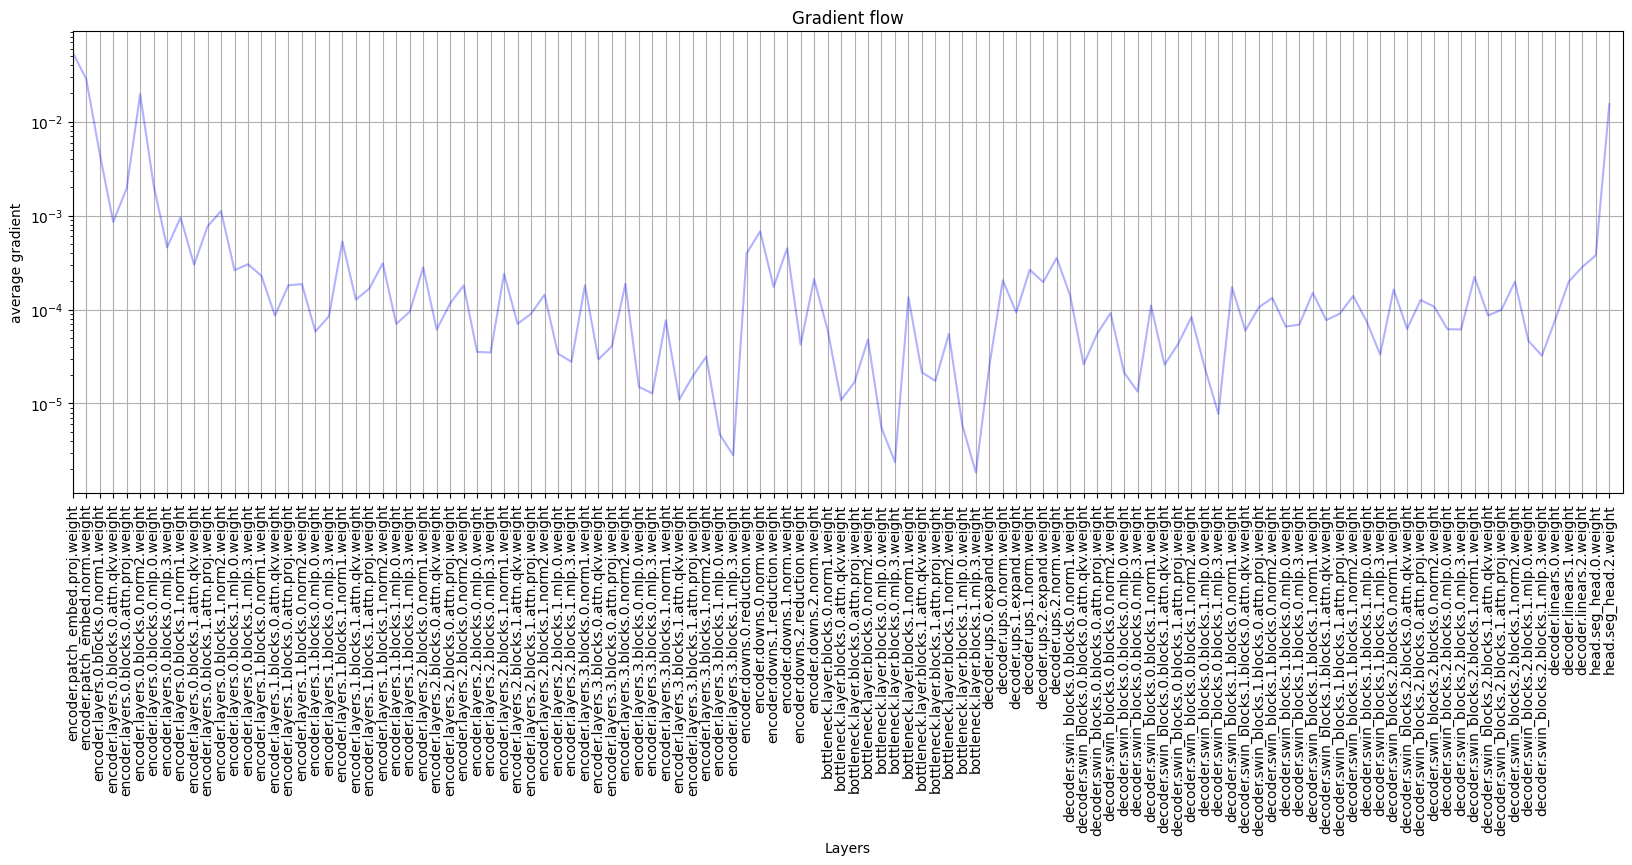

In [37]:
plot_grad_flow(model.named_parameters())

In [ ]:
# допустим, твоя текущая модель называется vae
save_path = "../models/SwinUnet_binary_segmentation_diffraction.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Модель сохранена в {save_path}")

✅ Модель сохранена в models/SwinUnet_binary_segmentation_diffraction.pth


In [39]:
import torch

class Qwrapper:
    def __init__(self, theta_range=(-170, 170), L_range=(0.1, 10), fixed_centers=None, device="cuda"):
        self.theta_range = theta_range
        self.L_range = L_range
        self.device = device

        if fixed_centers is None:
            raise ValueError("Нужно передать фиксированные центры каналов d.")

        centers = torch.tensor(fixed_centers, dtype=torch.float32)
        self.centers = centers.to(device)

        # Строим границы каналов
        edges = torch.zeros(len(centers) + 1, dtype=torch.float32)

        edges[1:-1] = (centers[:-1] + centers[1:]) * 0.5
        edges[0] = centers[0] - (centers[1] - centers[0]) * 0.5
        edges[-1] = centers[-1] + (centers[-1] - centers[-2]) * 0.5

        self.edges = edges.to(device)


    def tensor_to_d(self, batch_tensor):
        if batch_tensor.dim() != 4:
            raise ValueError("Ожидается тензор размера [B, 1, H, W]")

        B, _, H, W = batch_tensor.shape
        batch_tensor = batch_tensor.to(self.device)

        # формируем theta и L (Правильно!)
        theta_deg = torch.linspace(self.theta_range[0], self.theta_range[1], W, device=self.device)
        L_vals = torch.linspace(self.L_range[0], self.L_range[1], H, device=self.device)

        theta_rad = torch.deg2rad(theta_deg)  # [W]

        # meshgrid правильно: (H, W)
        # L зависит от строки, theta зависит от столбца
        L_grid, theta_grid = torch.meshgrid(L_vals, theta_rad, indexing="ij")
        # теперь:
        # L_grid:     [H, W]
        # theta_grid: [H, W]

        # вычисляем d
        d_grid = L_grid / (2 * torch.sin(torch.abs(theta_grid) * 0.5))

        # маска d <= 7.5
        mask = d_grid <= 7.5  # [H, W]

        results = []

        for b in range(B):
            I_mat = batch_tensor[b, 0]  # [H, W]

            # применяем маску
            d_vals = d_grid[mask]       # [N]
            I_vals = I_mat[mask]        # [N]

            # определяем индекс канала
            idx = torch.bucketize(d_vals, self.edges) - 1

            I_summed = torch.zeros(len(self.centers), device=self.device)
            I_summed.scatter_add_(0, idx.clamp(0, len(I_summed) - 1), I_vals)

            results.append({
                "d": self.centers.detach().cpu().numpy(),
                "I": I_summed.detach().cpu().numpy()
            })

        return results


Epoch 300 Val:   0%|          | 0/60 [00:00<?, ?it/s]

0.15213440358638763


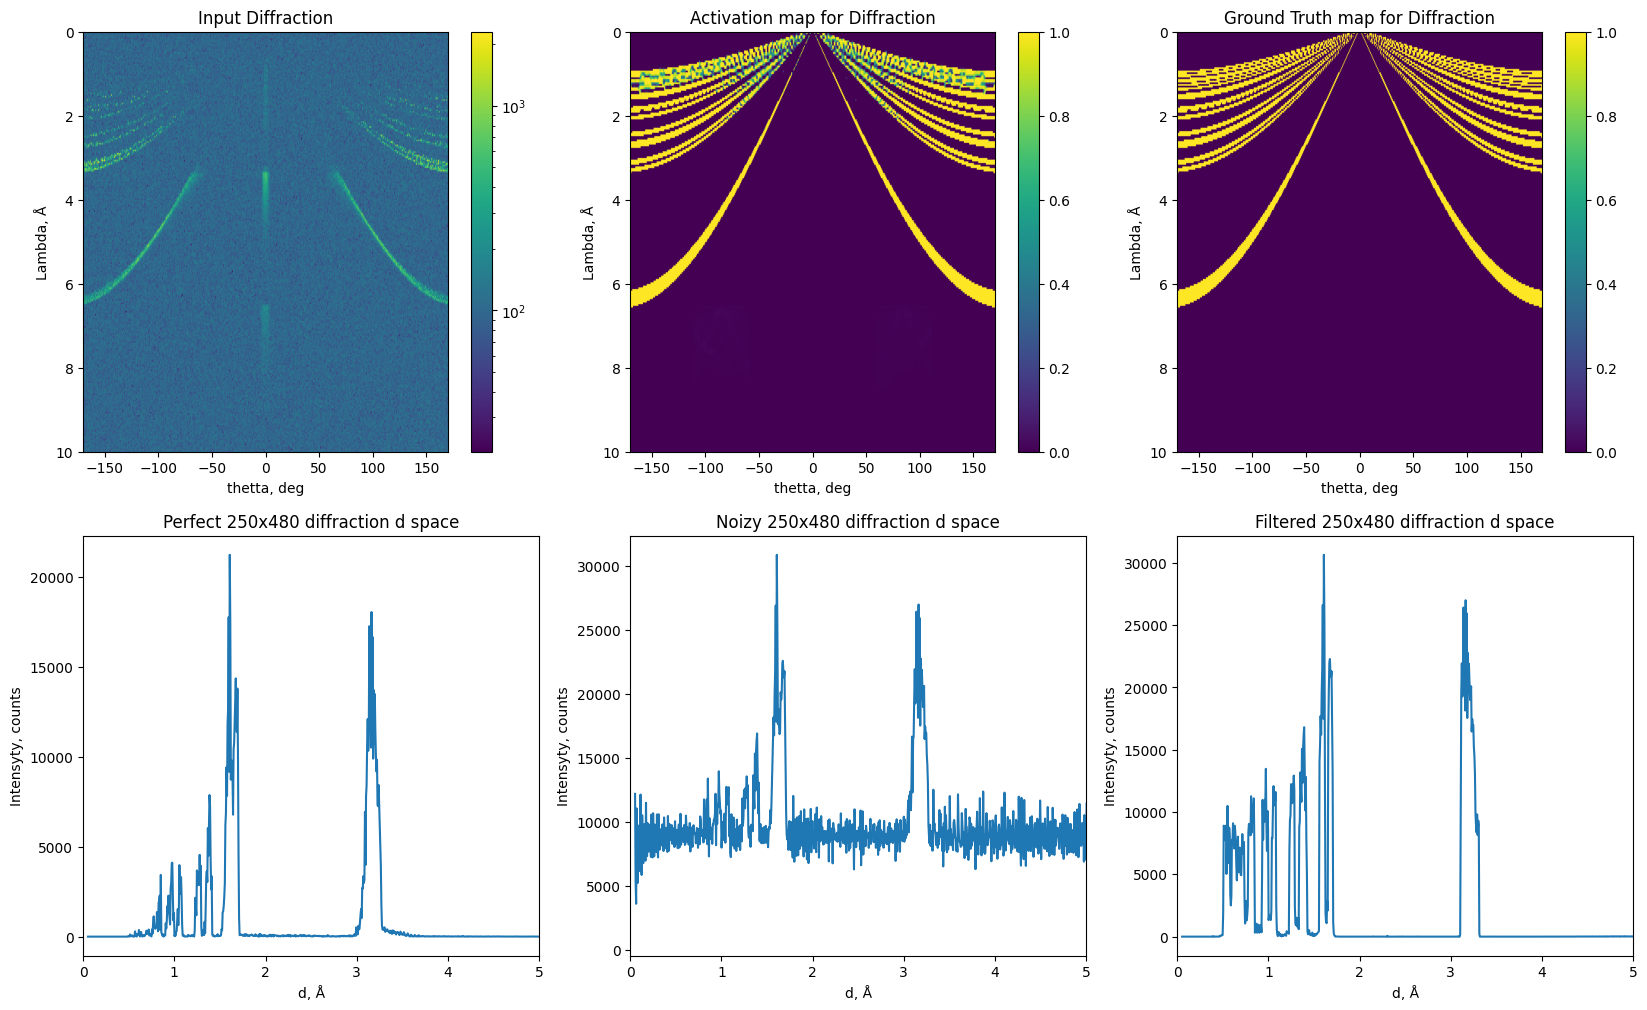

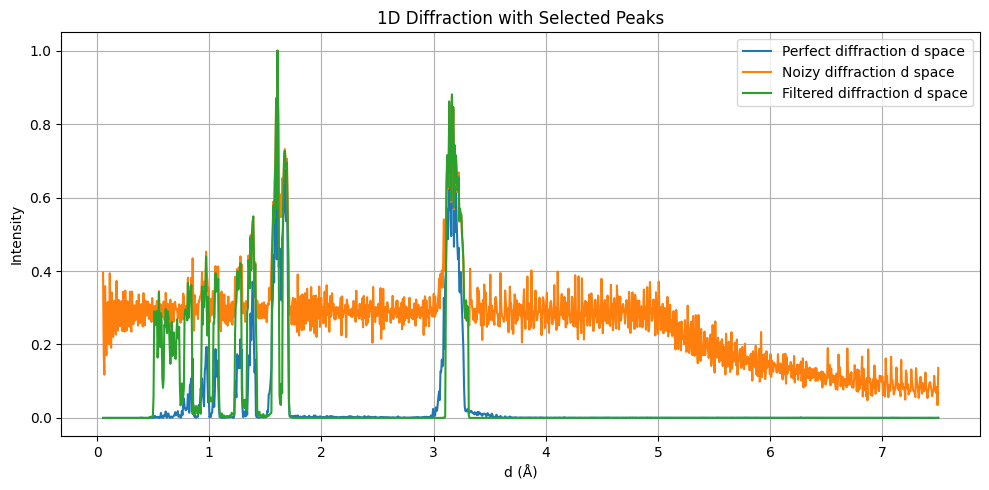

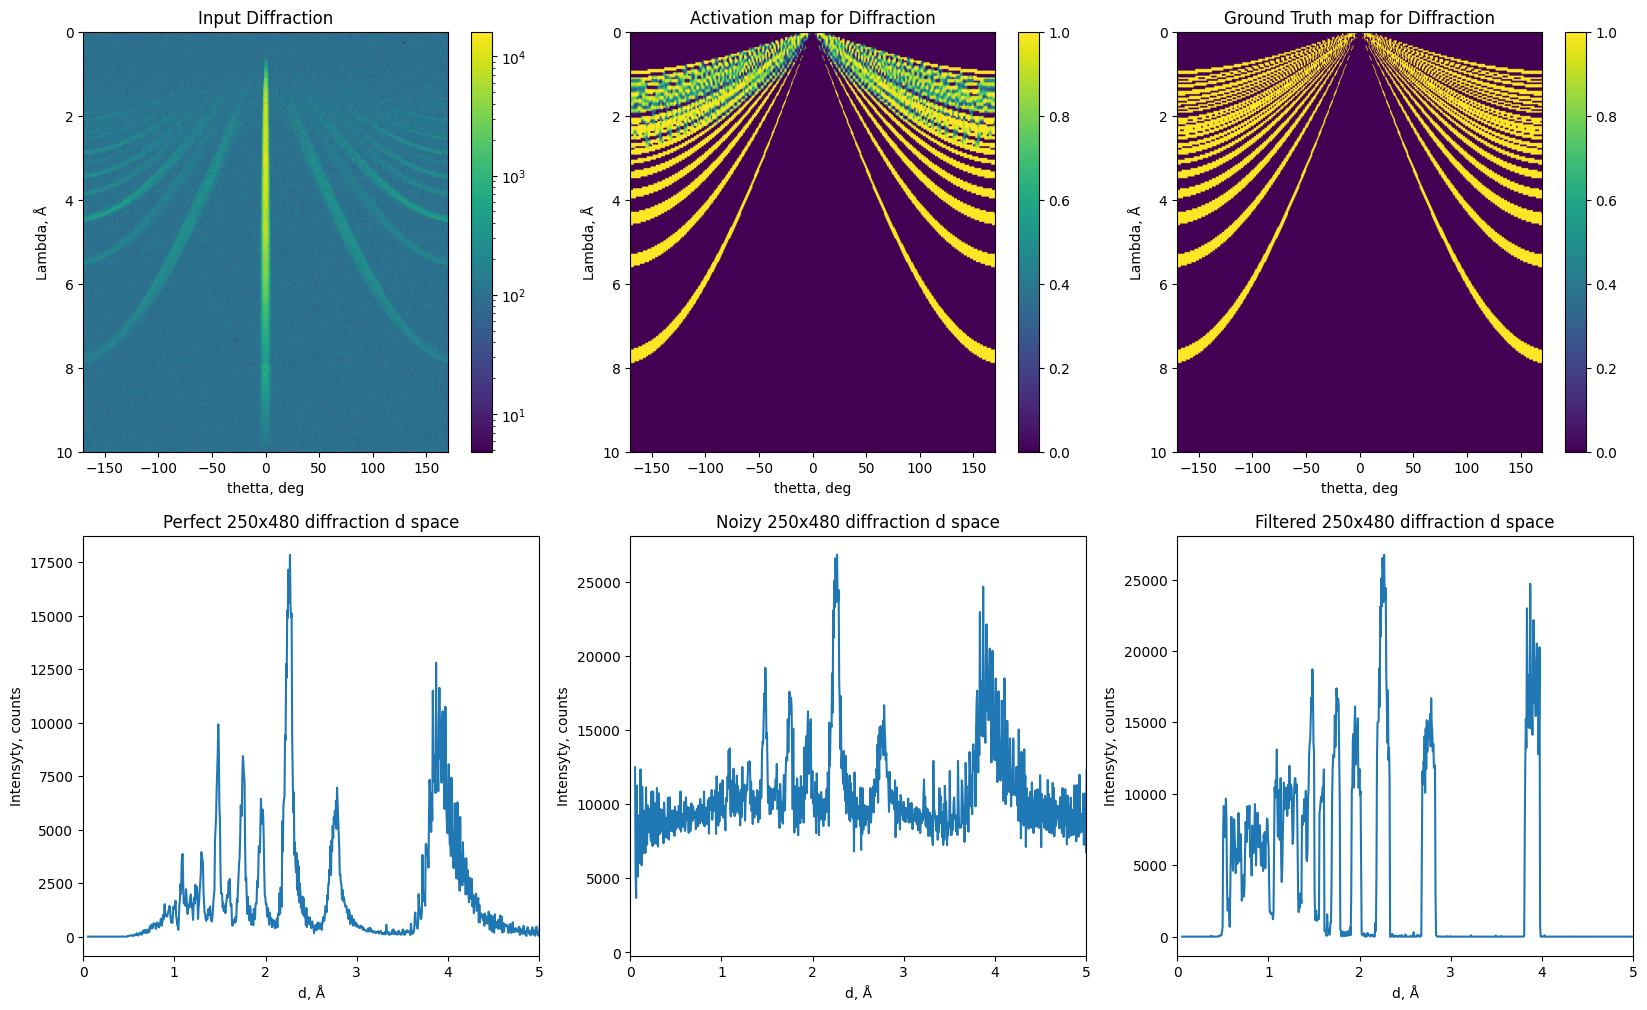

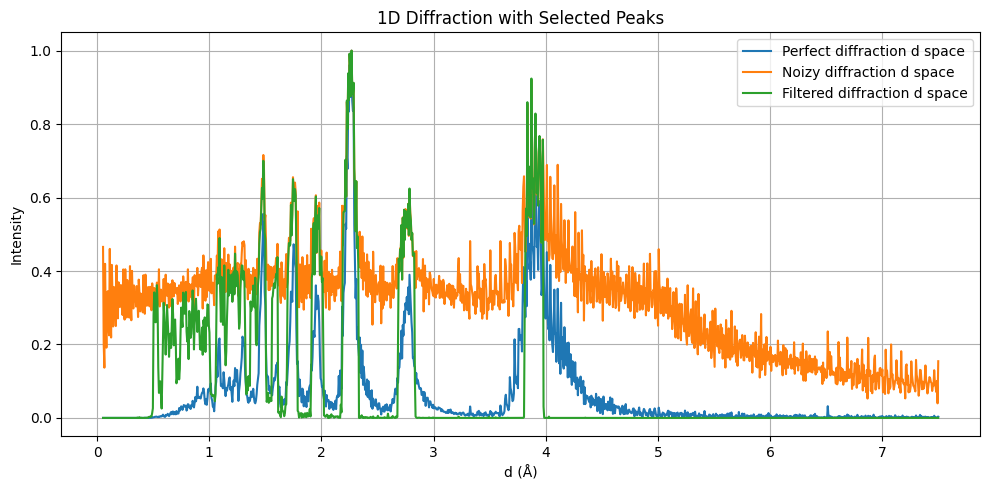

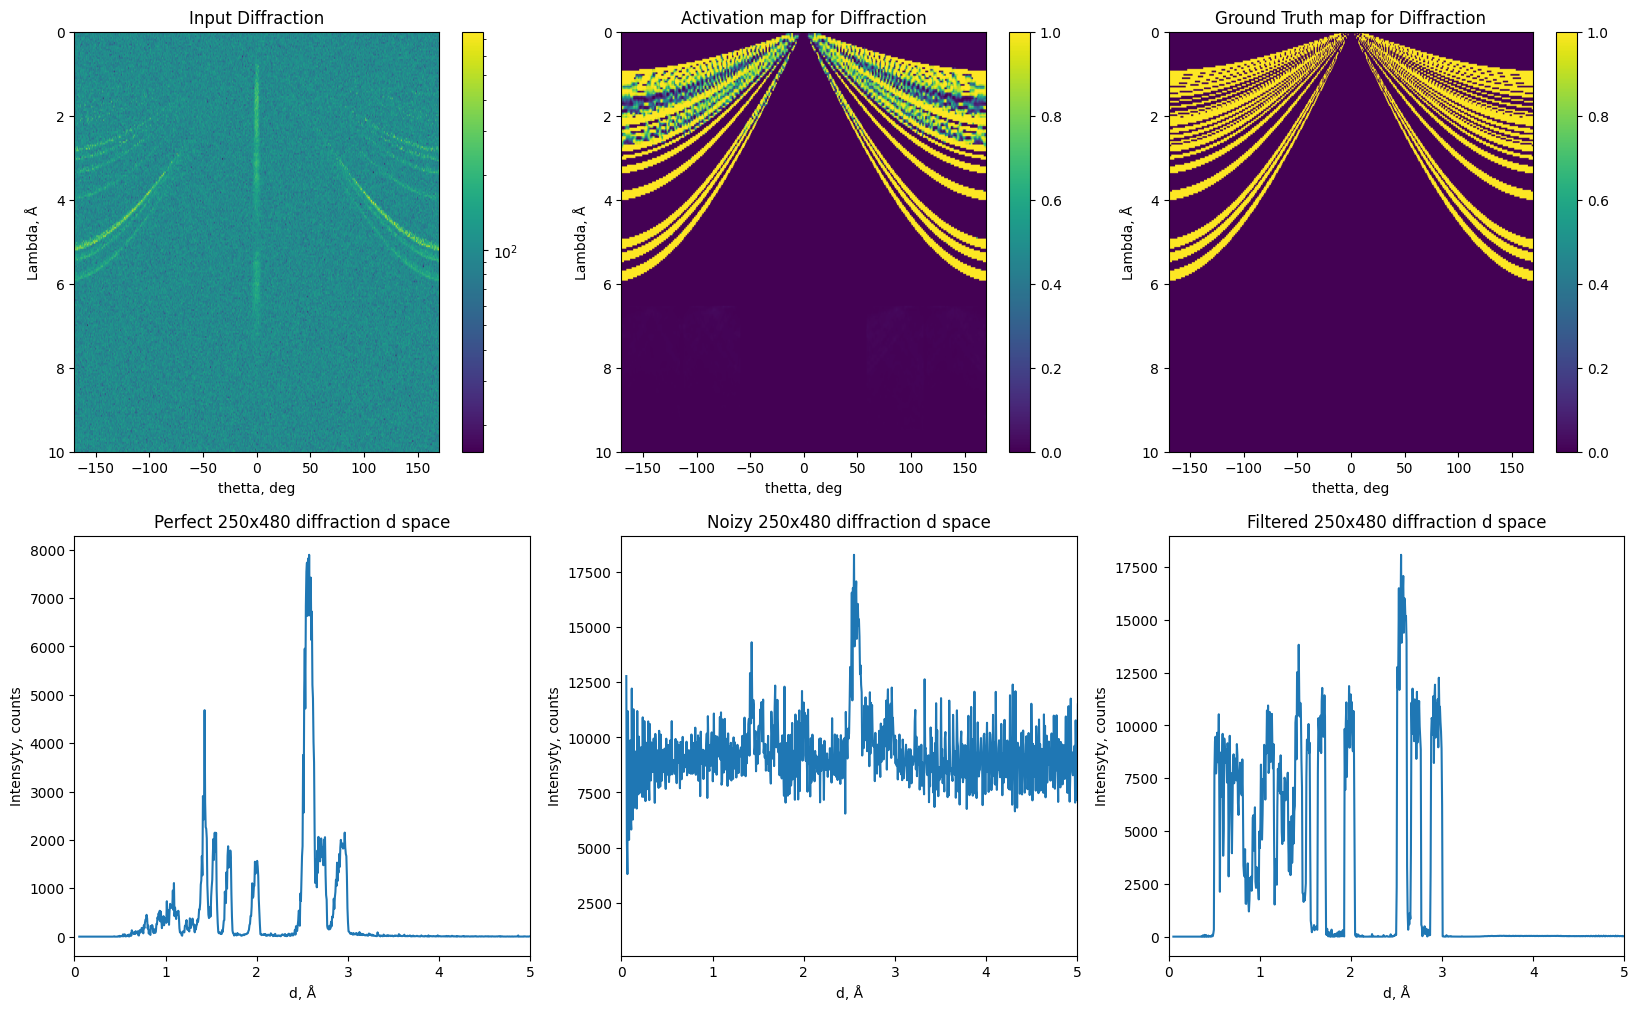

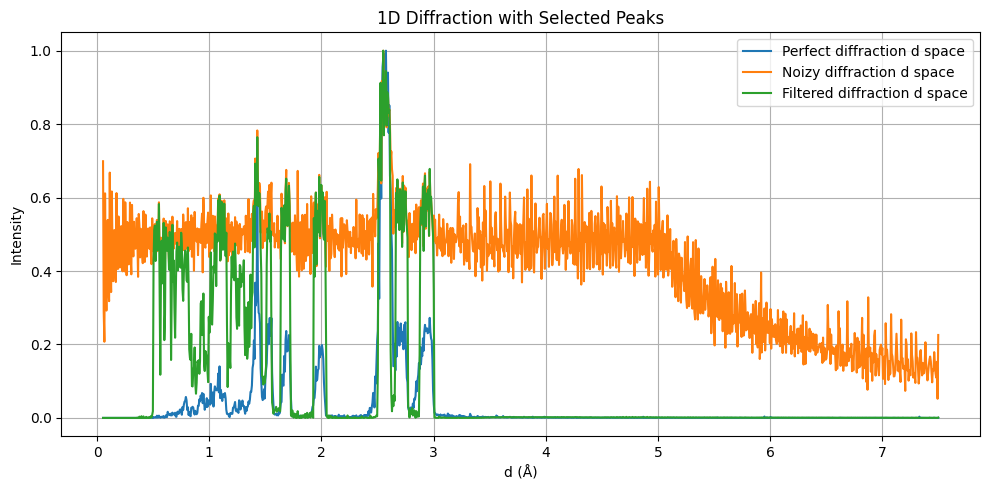

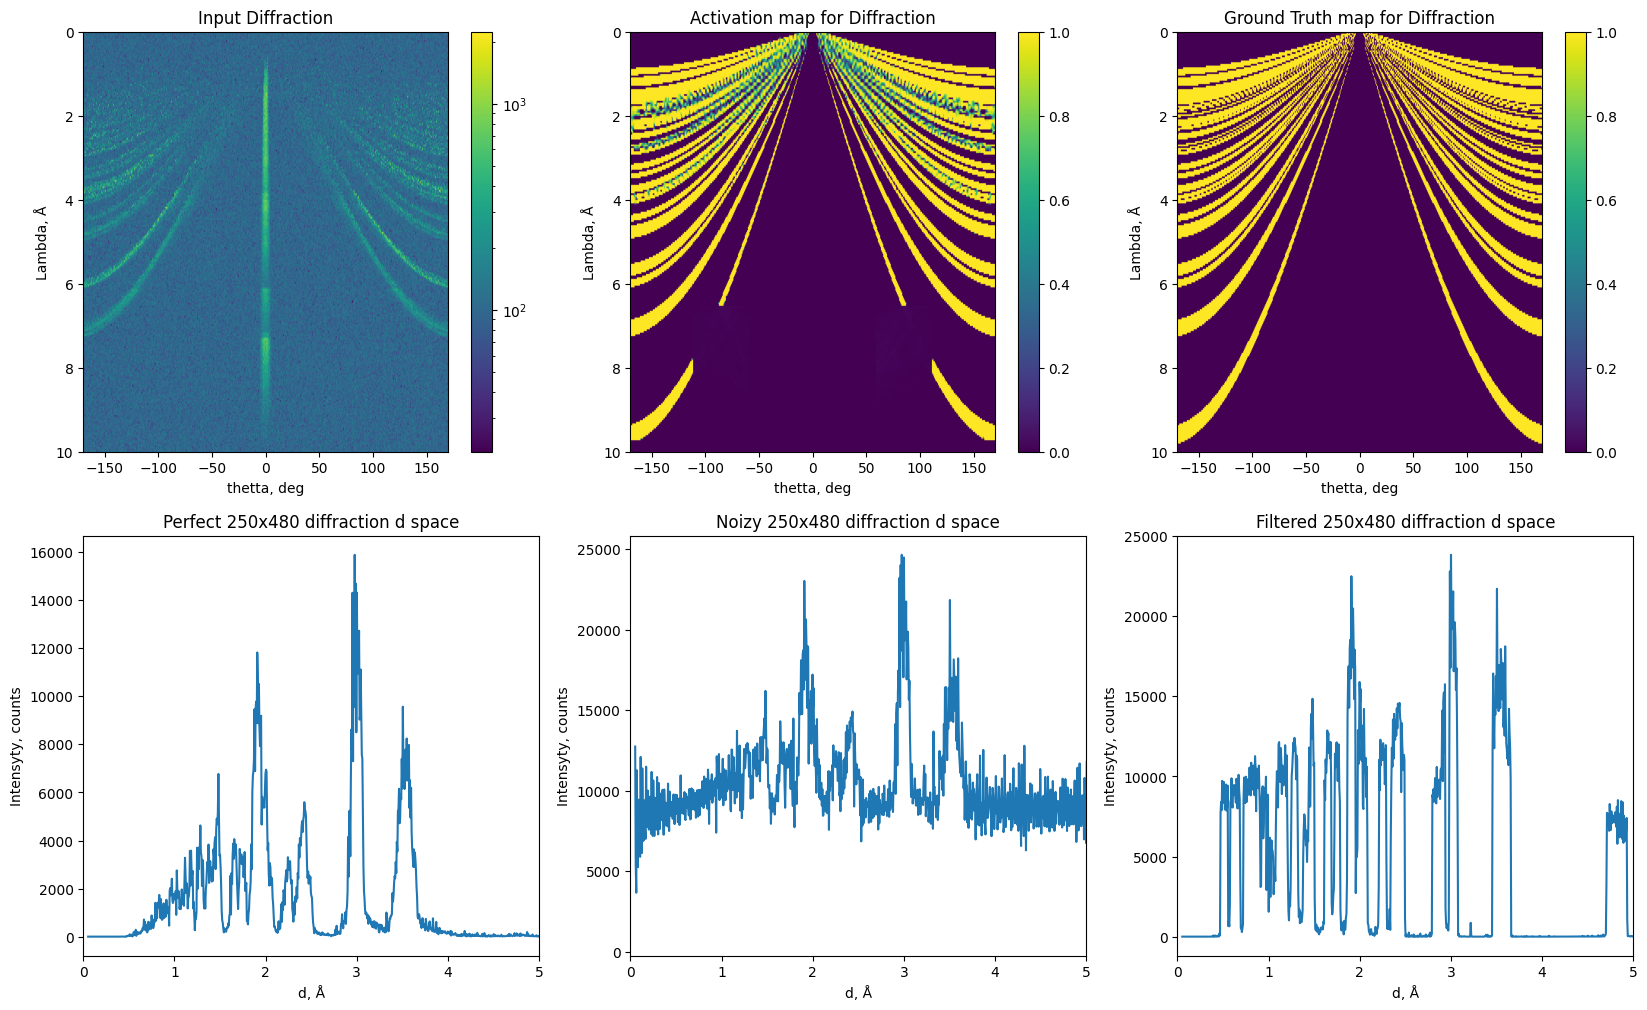

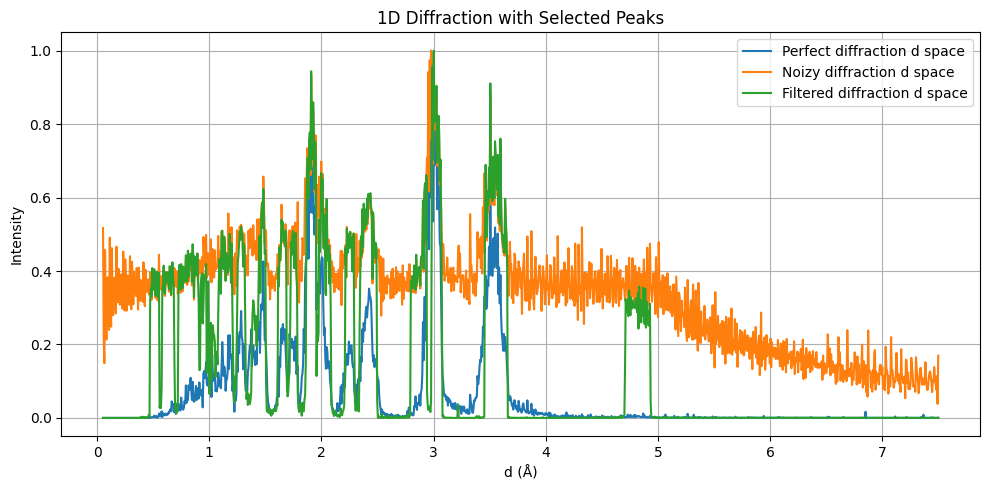

In [40]:
fixed_centers = np.linspace(0.05318052, 7.49710258, 1241)

qw = Qwrapper(
    theta_range=(-170, 170),
    L_range=(0.1, 10),
    fixed_centers=fixed_centers,
    device = "cpu"
)

loss_fn = CombinedLoss(w_bce=1.0, w_dice=1.0)

# Validation
model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1} Val", leave=False):
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        out1 = qw.tensor_to_d(images)

        # mu = random.randint(50, 200)
        mu = 100
        sigma = 0.2*mu
        
        # Создаем шум на том же устройстве
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise

        if use_fp16:
            # FP16 forward
            with autocast():
                pred = model(images)
                loss = loss_fn(pred, masks)
                activation_maps = torch.sigmoid(pred)       
        else:
            pred = model(images)
            loss = loss_fn(pred, masks)
            activation_maps = torch.sigmoid(pred)

        print(loss.item())

        result = images * activation_maps

        out2 = qw.tensor_to_d(images)
        out3 = qw.tensor_to_d(result)

        for i, (diffraction, activation_map,  mask) in enumerate(zip(images, activation_maps, masks)):

            # Создаем фигуру и оси
            fig, axes = plt.subplots(2, 3, figsize=(20, 12))
            ax1, ax2, ax3 = axes[0]  # Первая строка осей
            ax4, ax5, ax6 = axes[1]  # Вторая строка осей

            # Первый график
            im1 = ax1.imshow(diffraction[0].cpu().numpy(), cmap='viridis', aspect='auto', norm='log', extent=(-170, 170, 10, 0))
            ax1.set_title('Input Diffraction')
            ax1.set_xlabel('thetta, deg')
            ax1.set_ylabel('Lambda, Å')
            plt.colorbar(im1)

            ax4.plot(out1[i]["d"], out1[i]["I"])
            ax4.set_xlim(0, 5)
            #ax4.set_yscale('log')
            ax4.set_title(f"Perfect 250x480 diffraction d space")
            ax4.set_xlabel('d, Å')
            ax4.set_ylabel('Intensyty, counts')

            # Первый график
            im2 = ax2.imshow(activation_map[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
            ax2.set_title('Activation map for Diffraction')
            ax2.set_xlabel('thetta, deg')
            ax2.set_ylabel('Lambda, Å')
            plt.colorbar(im2)

            ax5.plot(out2[i]["d"], out2[i]["I"])
            ax5.set_xlim(0, 5)
            #ax4.set_yscale('log')
            ax5.set_title(f"Noizy 250x480 diffraction d space")
            ax5.set_xlabel('d, Å')
            ax5.set_ylabel('Intensyty, counts')

            # Первый график
            im3 = ax3.imshow(mask[0].cpu().numpy(), cmap='viridis', aspect='auto', extent=(-170, 170, 10, 0))
            ax3.set_title('Ground Truth map for Diffraction')
            ax3.set_xlabel('thetta, deg')
            ax3.set_ylabel('Lambda, Å')
            plt.colorbar(im3)

            ax6.plot(out3[i]["d"], out3[i]["I"])
            ax6.set_xlim(0, 5)
            #ax4.set_yscale('log')
            ax6.set_title(f"Filtered 250x480 diffraction d space")
            ax6.set_xlabel('d, Å')
            ax6.set_ylabel('Intensyty, counts')

            plt.show()

            # Plot overall diffraction pattern
            plt.figure(figsize=(10, 5))
            plt.plot(out1[i]["d"], out1[i]["I"] / max(out1[i]["I"]), label='Perfect diffraction d space')
            plt.plot(out2[i]["d"], out2[i]["I"] / max(out2[i]["I"]), label='Noizy diffraction d space')
            plt.plot(out3[i]["d"], out3[i]["I"] / max(out3[i]["I"]), label='Filtered diffraction d space')
            plt.xlabel("d (Å)")
            plt.ylabel("Intensity")
            plt.title("1D Diffraction with Selected Peaks")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        break

In [ ]:
from SwinUNet_old import SwinUNet

# Создание модели
model = SwinUNet(patch_size=2, in_chans=1, embed_dim=48, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.).to(device)

model.load_state_dict(torch.load("../models/SwinUnet_binary_segmentation_diffraction.pth", map_location=device))

<All keys matched successfully>

In [14]:
import torch

def binarize_prediction(pred_probs, threshold=0.5):
    """
    pred_probs: torch.Tensor [B,1,H,W], float in [0,1]
    """
    return (pred_probs >= threshold).to(torch.uint8)

def confusion_matrix_binary(pred_bin, gt_bin):
    """
    pred_bin, gt_bin: [B,1,H,W], uint8 {0,1}
    """
    pred = pred_bin.view(-1)
    gt   = gt_bin.view(-1)

    TP = torch.sum((pred == 1) & (gt == 1)).float()
    TN = torch.sum((pred == 0) & (gt == 0)).float()
    FP = torch.sum((pred == 1) & (gt == 0)).float()
    FN = torch.sum((pred == 0) & (gt == 1)).float()

    return TP, TN, FP, FN

def pixel_accuracy(TP, TN, FP, FN, eps=1e-8):
    return (TP + TN) / (TP + TN + FP + FN + eps)

def iou_score(TP, FP, FN, eps=1e-8):
    return TP / (TP + FP + FN + eps)

def dice_score(TP, FP, FN, eps=1e-8):
    return (2 * TP) / (2 * TP + FP + FN + eps)

def precision_score(TP, FP, eps=1e-8):
    return TP / (TP + FP + eps)

def recall_score(TP, FN, eps=1e-8):
    return TP / (TP + FN + eps)


In [15]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import binary_erosion

def extract_boundary(mask):
    """
    mask: [H,W] binary numpy array
    """
    eroded = binary_erosion(mask)
    boundary = mask ^ eroded
    return np.argwhere(boundary)

def compute_all_metrics(pred_probs, gt_mask, threshold=0.5):
    pred_bin = binarize_prediction(pred_probs, threshold)
    gt_bin   = gt_mask.to(torch.uint8)

    TP, TN, FP, FN = confusion_matrix_binary(pred_bin, gt_bin)

    metrics = {
        "PixelAccuracy": pixel_accuracy(TP, TN, FP, FN).item(),
        "IoU": iou_score(TP, FP, FN).item(),
        "Dice": dice_score(TP, FP, FN).item(),
        "Precision": precision_score(TP, FP).item(),
        "Recall": recall_score(TP, FN).item(),
    }

    return metrics


In [19]:
from tqdm import tqdm

use_fp16 = True

# Validation
model.eval()
metrics_25 = []
metrics_50 = []
metrics_75 = []
num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for images, masks in tqdm(test_loader):
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            # mu = random.randint(50, 200)
            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(images, device=device) * sigma + mu
            images = images + noise

            if use_fp16:
                # FP16 forward
                with torch.cuda.amp.autocast():
                    pred = model(images)
                    activation_maps = torch.sigmoid(pred)       
            else:
                pred = model(images)
                activation_maps = torch.sigmoid(pred)


            for i, (activation_map,  mask) in enumerate(zip(activation_maps, masks)):

                activation_map = activation_map.unsqueeze(0)
                mask = mask.unsqueeze(0)

                metrics_25.append(compute_all_metrics(activation_map, mask, threshold=0.25))
                metrics_50.append(compute_all_metrics(activation_map, mask, threshold=0.5))
                metrics_75.append(compute_all_metrics(activation_map, mask, threshold=0.75))

100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


In [ ]:
import json

with open("../results/SwinUnet_pretrain_segmentation_metrics.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "metrics_25": metrics_25,
            "metrics_50": metrics_50,
            "metrics_75": metrics_75
        },
        f,
        indent=4,
        ensure_ascii=False
    )


In [ ]:
with open("../results/SwinUnet_pretrain_segmentation_metrics.json", "r", encoding="utf-8") as f:
    data = json.load(f)

metrics_25 = data["metrics_25"]
metrics_50 = data["metrics_50"]
metrics_75 = data["metrics_75"]

In [24]:
import numpy as np

def extract_metric(metrics_list, metric_name):
    return np.array([m[metric_name] for m in metrics_list])

metrics_names = ["PixelAccuracy", "IoU", "Dice", "Precision", "Recall"]

for metric_name in metrics_names:
    print(metric_name)
    arr_25 = extract_metric(metrics_25, metric_name)
    mean_25 = np.mean(arr_25)
    std_25 = np.std(arr_25)
    print(f'0.25 thrashold {metric_name}: mean: {mean_25}, std: {std_25}')

    arr_50 = extract_metric(metrics_50, metric_name)
    mean_50 = np.mean(arr_50)
    std_50 = np.std(arr_50)
    print(f'0.50 thrashold {metric_name}: mean: {mean_50}, std: {std_50}')

    arr_75 = extract_metric(metrics_75, metric_name)
    mean_75 = np.mean(arr_75)
    std_75 = np.std(arr_75)
    print(f'0.75 thrashold {metric_name}: mean: {mean_75}, std: {std_75}')

    print('-----------------------------------------------------------------------')

PixelAccuracy
0.25 thrashold PixelAccuracy: mean: 0.965241124878327, std: 0.02939716848082998
0.50 thrashold PixelAccuracy: mean: 0.9679544087251027, std: 0.03020251544514184
0.75 thrashold PixelAccuracy: mean: 0.9649345136185488, std: 0.031689880306800096
-----------------------------------------------------------------------
IoU
0.25 thrashold IoU: mean: 0.7874269799739705, std: 0.1361292473966406
0.50 thrashold IoU: mean: 0.7970331009718696, std: 0.1449809591331591
0.75 thrashold IoU: mean: 0.7693836283945287, std: 0.15192206338142955
-----------------------------------------------------------------------
Dice
0.25 thrashold Dice: mean: 0.8722266809336725, std: 0.1184494319425275
0.50 thrashold Dice: mean: 0.8770676339744993, std: 0.12609789662095638
0.75 thrashold Dice: mean: 0.8582356487273561, std: 0.13528773342834288
-----------------------------------------------------------------------
Precision
0.25 thrashold Precision: mean: 0.8472731147209803, std: 0.07402808284394155
0.50 

In [49]:
from collections import defaultdict

compound_data = defaultdict(lambda: {
    "probs": [],
    "gt": [],
    "pred_maps": [],
    "gt_maps": []
})


# Validation
model.eval()

with torch.no_grad():
    for images, masks, compound_id in zip(df_test_tensor, GT_test_tensor, tesr_samples):
        images = images.unsqueeze(0).to(device)
        masks = masks.unsqueeze(0).to(device)

        # mu = random.randint(50, 200)
        mu = 100
        sigma = 0.2*mu
        
        # Создаем шум на том же устройстве
        noise = torch.randn_like(images, device=device) * sigma + mu
        images = images + noise

        if use_fp16:
            # FP16 forward
            with autocast():
                pred = model(images)
                activation_maps = torch.sigmoid(pred)       
        else:
            pred = model(images)
            activation_maps = torch.sigmoid(pred)

        # ---------- ROC-AUC (pixel-wise, no threshold) ----------
        probs_flat = activation_maps[0, 0].flatten().cpu().numpy()
        gt_flat    = masks[0, 0].flatten().cpu().numpy()

        compound_data[compound_id]["probs"].append(probs_flat)
        compound_data[compound_id]["gt"].append(gt_flat)

        # ---------- IoU(threshold) ----------
        compound_data[compound_id]["pred_maps"].append(
            activation_maps[0, 0].cpu()
        )
        compound_data[compound_id]["gt_maps"].append(
            masks[0, 0].cpu()
        )

In [50]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import torch

def roc_curve_per_compound(compound_entry):
    probs = np.concatenate(compound_entry["probs"])
    gt    = np.concatenate(compound_entry["gt"])

    # если только один класс — ROC не определён
    if len(np.unique(gt)) < 2:
        return None

    fpr, tpr, _ = roc_curve(gt, probs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

def iou_vs_threshold_per_compound(compound_entry, thresholds):
    iou_curves = []

    for pred_map, gt_map in zip(
        compound_entry["pred_maps"],
        compound_entry["gt_maps"]
    ):
        sample_ious = []

        for t in thresholds:
            pred_bin = (pred_map >= t).to(torch.uint8)
            gt_bin   = gt_map.to(torch.uint8)

            TP = torch.sum((pred_bin == 1) & (gt_bin == 1)).float()
            FP = torch.sum((pred_bin == 1) & (gt_bin == 0)).float()
            FN = torch.sum((pred_bin == 0) & (gt_bin == 1)).float()

            iou = TP / (TP + FP + FN + 1e-8)
            sample_ious.append(iou.item())

        iou_curves.append(sample_ious)

    iou_curves = np.array(iou_curves)

    return {
        "median": np.nanmedian(iou_curves, axis=0),
        "q25": np.nanpercentile(iou_curves, 25, axis=0),
        "q75": np.nanpercentile(iou_curves, 75, axis=0),
    }


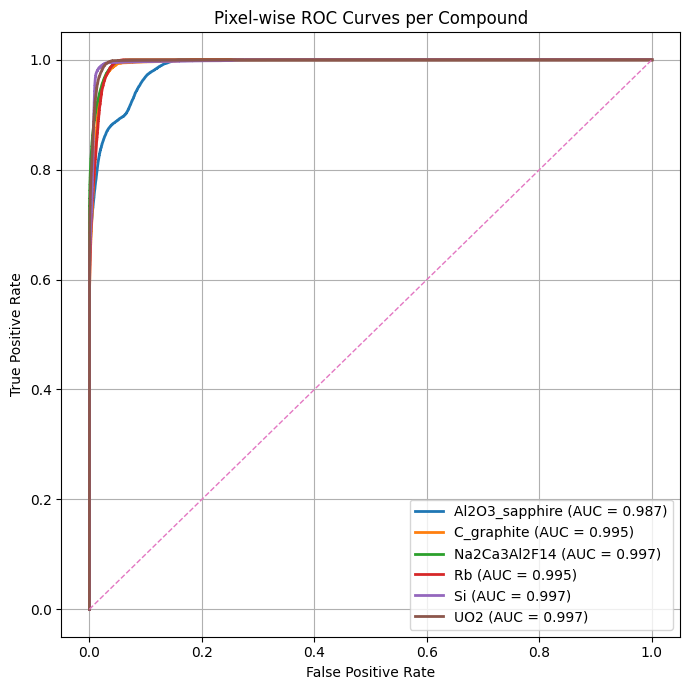

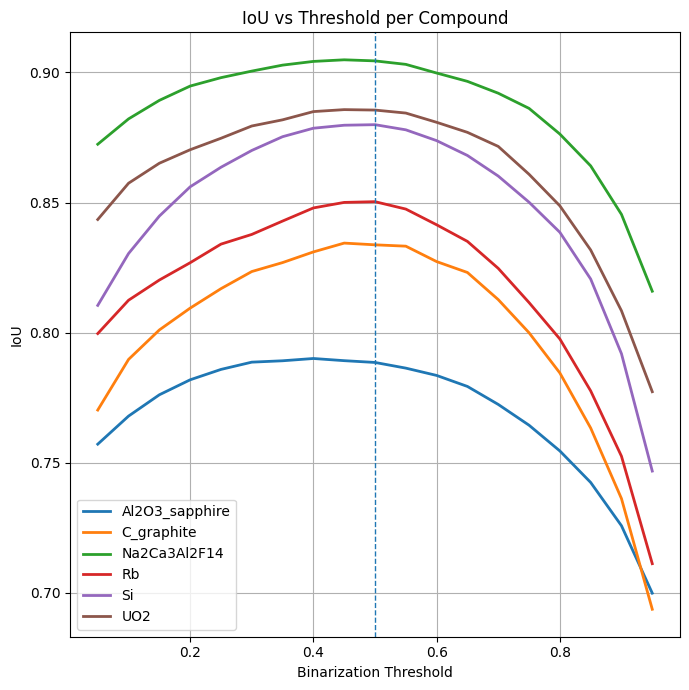

In [53]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0.05, 0.95, 19)

results = {}

for compound_id, entry in compound_data.items():
    roc_res = roc_curve_per_compound(entry)
    iou_res = iou_vs_threshold_per_compound(entry, thresholds)

    results[compound_id] = {
        "roc": roc_res,
        "iou": iou_res
    }

plt.figure(figsize=(7, 7))

for compound_id, res in results.items():
    roc_res = res["roc"]
    if roc_res is None:
        continue

    fpr, tpr, roc_auc = roc_res
    plt.plot(
        fpr, tpr,
        linewidth=2,
        label=f"{compound_id} (AUC = {roc_auc:.3f})"
    )

# Диагональ случайного классификатора
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pixel-wise ROC Curves per Compound")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))

for compound_id, res in results.items():
    iou_res = res["iou"]

    plt.plot(
        thresholds,
        iou_res["median"],
        linewidth=2,
        label=f"{compound_id}"
    )

# Вертикальная линия выбранного порога
plt.axvline(0.5, linestyle='--', linewidth=1)

plt.xlabel("Binarization Threshold")
plt.ylabel("IoU")
plt.title("IoU vs Threshold per Compound")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
